# National-level analysis

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['mathtext.rm'] = 'Avenir'
plt.rcParams['mathtext.it'] = 'Avenir:italic'
plt.rcParams['mathtext.bf'] = 'Avenir:bold'
plt.rcParams['font.size'] = 20
plt.rcParams['pdf.fonttype'] = 42

In [2]:
def get_weather(x):
    return x['gdd']*beta_gdd + x['edd']*beta_edd + x['prcp']*beta_prcp + x['prcp2']*beta_prcp2

In [3]:
coef = pd.read_csv('../../data/yield/baseline_coeffs+95.csv', index_col=0)
beta_gdd = coef.loc['gdd']['coeff']
beta_edd = coef.loc['edd']['coeff']
beta_prcp = coef.loc['prcp']['coeff']
beta_prcp2 = coef.loc['prcp2']['coeff']

In [4]:
# Read in GMFD data
gmfd = pd.read_csv('../../data/yield/baseline_model_gmfd_historical.csv')
gmfd["fips"] = gmfd["fips"].astype(str).str.zfill(5)
gmfd['prcp2'] = gmfd['prcp']**2
gmfd['weather'] = gmfd.apply(get_weather, axis=1)

yield_fips = gmfd['fips'].unique() # Only take fips codes
#### Note that the regression coefficients from R are only valid for counties with USDA records n>25 (as we chose), 
#### so we subset to these counties for the yield analysis.

## Figure 1

In [5]:
# Read in NEX models
nex_models = !ls ../../data/climate/NEX-GDDP/hist
nex = {model.replace("agvar_historical_r1i1p1_","").replace(".csv","") : pd.read_csv("../../data/climate/NEX-GDDP/hist/" + model) for model in nex_models}
nex_models = [model.replace("agvar_historical_r1i1p1_","").replace(".csv","") for model in nex_models]

# NEX weather
for model in nex_models:
    tmp = nex[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    nex[model] = tmp

In [6]:
# Read in CMIP models
cmip_models = !ls ../../data/climate/CMIP
cmip = {model.replace("agvar_","").replace("_historical","").replace(".csv","") : pd.read_csv("../../data/climate/CMIP/" + model) for model in cmip_models}
cmip_models = [model.replace("agvar_","").replace("_historical","").replace(".csv","") for model in cmip_models]

# CMIP weather
for model in cmip_models:
    tmp = cmip[model].query('year < 2006').copy()
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    cmip[model] = tmp

In [7]:
# Construct national weights (total production by weighted sum of counties) (only 1956-2005)
weights = pd.read_csv('../../data/usda/maize_county_yield_area.csv').filter(["fips", "year", "area","yield"])
weights = weights.query('year >= 1956 and year <= 2005')
weights['fips'] = weights['fips'].astype(str).str.zfill(5)
weights.sort_values(by = ['fips', 'year'], inplace = True)
weights.set_index(['fips', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["fips","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['fips','year']).sort_index()
weights = weights.filter(['national_weight'])

In [8]:
# Weight by production

# NEX
nex_weather_weighted = {}
for model in nex_models:
    tmp = nex[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    nex_weather_weighted[model] = tmp
    
# CMIP
cmip_weather_weighted = {}
for model in cmip_models:
    tmp = cmip[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    cmip_weather_weighted[model] = tmp
    
# GMFD
gmfd_weather_weighted = pd.merge(gmfd.drop(columns='state'), weights.reset_index(), on = ['fips','year'], how = 'inner')
for col in gmfd_weather_weighted.columns[2:-1]:
    gmfd_weather_weighted[col] = gmfd_weather_weighted[col] * gmfd_weather_weighted['national_weight']
gmfd_weather_weighted = gmfd_weather_weighted.groupby(['year']).sum()
gmfd_weather_weighted = gmfd_weather_weighted.apply(lambda x: x/x['national_weight'], axis=1)
gmfd_weather_weighted.drop(columns='national_weight', inplace=True)

In [9]:
# NEX
nex_mean_error = [(nex_weather_weighted[model]['weather'].mean() - gmfd_weather_weighted['weather'].mean()) / gmfd_weather_weighted['weather'].mean() * 100 for model in nex_models]
nex_sd_error = [(nex_weather_weighted[model]['weather'].std() - gmfd_weather_weighted['weather'].std()) / gmfd_weather_weighted['weather'].std() * 100 for model in nex_models]
nex_q10_error = [(nex_weather_weighted[model]['weather'].quantile(q=0.1) - gmfd_weather_weighted['weather'].quantile(q=0.1)) / gmfd_weather_weighted['weather'].quantile(q=0.1) * 100 for model in nex_models]
nex_min_error = [(nex_weather_weighted[model]['weather'].min() - gmfd_weather_weighted['weather'].min()) / gmfd_weather_weighted['weather'].min() * 100 for model in nex_models]

# CMIP
cmip_mean_error = [(cmip_weather_weighted[model]['weather'].mean() - gmfd_weather_weighted['weather'].mean()) / gmfd_weather_weighted['weather'].mean() * 100 for model in cmip_models]
cmip_sd_error = [(cmip_weather_weighted[model]['weather'].std() - gmfd_weather_weighted['weather'].std()) / gmfd_weather_weighted['weather'].std() * 100 for model in cmip_models]
cmip_q10_error = [(cmip_weather_weighted[model]['weather'].quantile(q=0.1) - gmfd_weather_weighted['weather'].quantile(q=0.1)) / gmfd_weather_weighted['weather'].quantile(q=0.1) * 100 for model in cmip_models]
cmip_min_error = [(cmip_weather_weighted[model]['weather'].min() - gmfd_weather_weighted['weather'].min()) / gmfd_weather_weighted['weather'].min() * 100 for model in cmip_models]

In [13]:
# Full range
print(np.min(nex_min_error), np.max(nex_min_error))
# Median
np.median(nex_min_error)

63.14633324906437 232.99611883871796


161.88174177235874

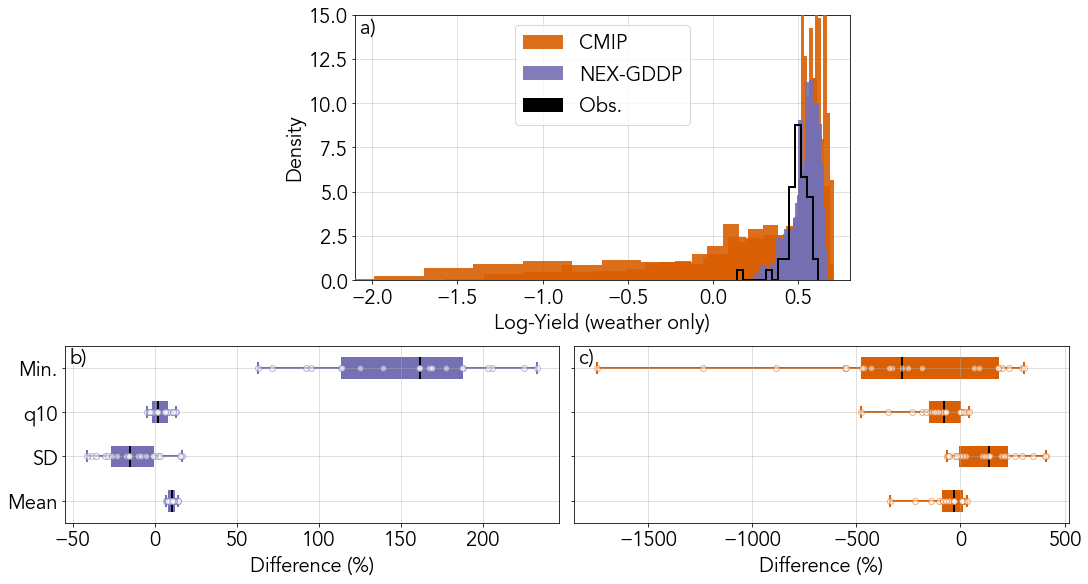

In [31]:
# All plot
fig = plt.figure(constrained_layout=True, figsize=(15,8))
gs = GridSpec(2, 4, figure=fig, height_ratios=[1.5,1], wspace=0.05)
ax1 = fig.add_subplot(gs[0, 1:-1])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:])

###############
# Plot style
###############
model_lw = 1.5
obs_lw = 2
model_alpha = 0.9
nex_col = '#7570b3'
cmip_col = '#d95f02'


######## Hist plot
ax=ax1

# Legend
ax.hist(cmip_weather_weighted[cmip_models[0]]['weather'], lw=model_lw, bins='fd', color=cmip_col, alpha=model_alpha, label='CMIP', density=True, zorder=10)
ax.hist(nex_weather_weighted[nex_models[0]]['weather'], lw=model_lw, bins='fd', color=nex_col, alpha=model_alpha, label='NEX-GDDP', density=True, zorder=10)
ax.hist([100], lw=model_lw, color='black', label='Obs.')
ax.set_xlim([-2.1, 0.8])
ax.legend(loc='upper center')

# CMIP
for model in cmip_models[1:]:
    ax.hist(cmip_weather_weighted[model]['weather'], lw=model_lw, bins='fd', color=cmip_col, alpha=model_alpha, label=None, density=True, zorder=10)

# NEX
for model in nex_models[1:]:
    ax.hist(nex_weather_weighted[model]['weather'], lw=model_lw, bins='fd', color=nex_col, alpha=model_alpha, label=None, density=True, zorder=10)

# GMFD
ax.hist(gmfd_weather_weighted['weather'], lw=obs_lw, bins='fd', histtype='step', color='black', label=None, density=True, zorder=10)

ax.set_ylim([0,15])
ax.grid(alpha=0.5, zorder=1)
ax.set_ylabel('Density')
ax.set_xlabel('Log-Yield (weather only)')
ax.text(0.01, 0.93, 'a)', transform=ax.transAxes)

########## Errors plot

# NEX
ax=ax2
nex_bxplt = ax.boxplot([nex_mean_error, nex_sd_error, nex_q10_error, nex_min_error],
                       positions=[1,2,3,4],
                       patch_artist=True,
                       medianprops=dict(linewidth=2, color='black'),
                       boxprops=dict(linewidth=2, color=nex_col),
                       whiskerprops=dict(linewidth=2, color=nex_col),
                       capprops=dict(linewidth=2, color=nex_col),
                       showfliers=False,
                       whis=(0,100),
                       vert=False,
                       zorder=1)

for patch in nex_bxplt['boxes']:
        patch.set_facecolor(nex_col)
        
ax.scatter(nex_min_error, [4 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(nex_q10_error, [3 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(nex_sd_error, [2 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(nex_mean_error, [1 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
        
ax.set_yticks([1,2,3,4])
ax.set_yticklabels(['Mean', 'SD', 'q10', 'Min.'])
ax.set_xlabel('Difference (%)')
ax.grid(alpha=0.5)
ax.text(0.01, 0.9, 'b)', transform=ax.transAxes)

# CMIP
ax=ax3
cmip_bxplt = ax.boxplot([cmip_mean_error, cmip_sd_error, cmip_q10_error, cmip_min_error],
                        positions=[1,2,3,4],
                        patch_artist=True,
                        medianprops=dict(linewidth=2, color='black'),
                        boxprops=dict(linewidth=2, color=cmip_col),
                        whiskerprops=dict(linewidth=2, color=cmip_col),
                        capprops=dict(linewidth=2, color=cmip_col),
                        showfliers=False,
                        whis=(0,100),
                        vert=False,
                        zorder=1)

for patch in cmip_bxplt['boxes']:
        patch.set_facecolor(cmip_col)
        
ax.scatter(cmip_min_error, [4 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(cmip_q10_error, [3 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(cmip_sd_error, [2 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(cmip_mean_error, [1 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)

ax.set_xlabel('Difference (%)')
ax.set_yticklabels(['', '', '', ''])
ax.grid(alpha=0.5)
ax.text(0.01, 0.9, 'c)', transform=ax.transAxes)

plt.savefig('../../figs/new/Figure1.pdf')
# plt.show()

## Figure 4

In [14]:
# Read in NEX models
nex_models = !ls ../../data/climate/NEX-GDDP/rcp85
nex = {model.replace("agvar_rcp85_r1i1p1_","").replace(".csv","") : pd.read_csv("../../data/climate/NEX-GDDP/rcp85/" + model) for model in nex_models}
nex_models = [model.replace("agvar_rcp85_r1i1p1_","").replace(".csv","") for model in nex_models]

# NEX weather
for model in nex_models:
    tmp = nex[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    nex[model] = tmp

In [15]:
# Read in CMIP models
cmip_models = !ls ../../data/climate/CMIP/
cmip = {model.replace("agvar_","").replace(".historical","").replace(".csv","") : pd.read_csv("../../data/climate/CMIP/" + model) for model in cmip_models}
cmip_models = [model.replace("agvar_","").replace(".historical","").replace(".csv","") for model in cmip_models]

# CMIP weather
for model in cmip_models:
    tmp = cmip[model].query('year >= 2006').copy()
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    cmip[model] = tmp

In [16]:
# Construct national weights (total production by weighted sum of counties)
weights = pd.read_csv('../../data/usda/maize_county_yield_area.csv').filter(["fips", "year", "area","yield"])
weights['fips'] = weights['fips'].astype(str).str.zfill(5)
weights.sort_values(by = ['fips', 'year'], inplace = True)
weights.set_index(['fips', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])

# Normalise
weights = pd.merge(weights.reset_index().filter(["fips","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['fips','year']).sort_index()
weights = weights.filter(['national_weight'])

# Average historical (1980-2020)
weights_agg = weights.query('year >= 1980').groupby('fips').sum()
weights_agg = weights_agg.loc[yield_fips]
weights_agg['national_weight'] = weights_agg['national_weight'] / weights_agg['national_weight'].sum()

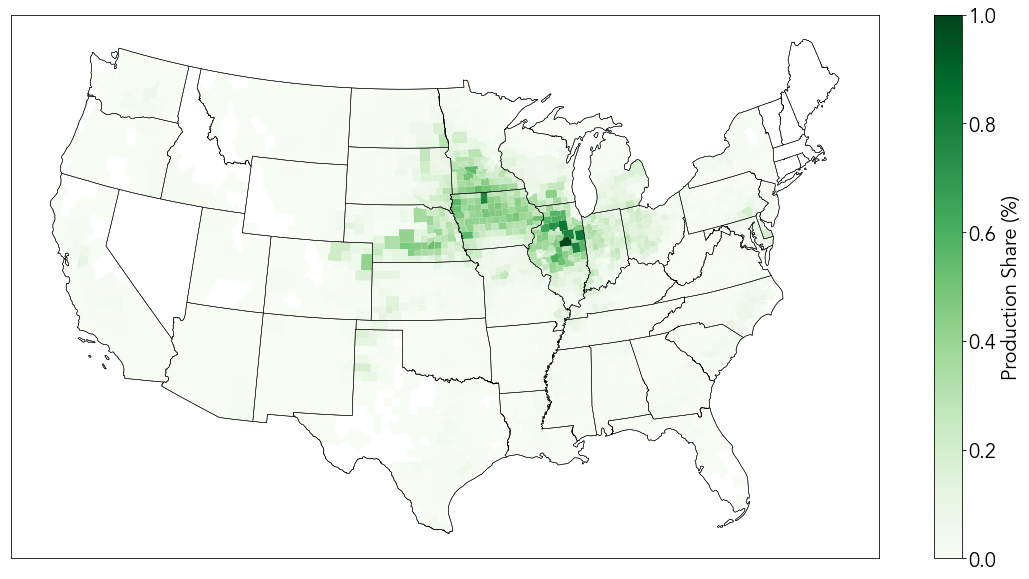

In [35]:
###########################
############ Weights plot
###########################

# Average all (1950-2020)
weights_agg_plot = weights.query('year >= 1950').groupby('fips').sum()
weights_agg_plot['national_weight'] = weights_agg_plot['national_weight'] / weights_agg_plot['national_weight'].sum()

# Plotting tools
import geopandas as gp
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

cm_data = np.loadtxt("../../other/plotting_tools/turku.txt")[::-1]
turku_map = LinearSegmentedColormap.from_list('turku', cm_data)

# Import plotting shapefiles
county_shp = gp.read_file('../../other/plotting_tools/counties_contig_plot.shp')
county_shp["fips"] = county_shp["fips"].astype(str).str.zfill(5)

# Add State filter for plot
county_shp_plot = county_shp.copy()
county_shp_plot['state'] = county_shp_plot['fips'].str[:2]
county_shp_plot.set_index(['state'], inplace=True)
county_shp_plot.set_index(['fips'], inplace=True)

states = gp.read_file('../../other/plotting_tools/states_contig_plot.shp')
coast = gp.read_file('../../other/plotting_tools/coast_contig_plot.shp')

############# 
## Plot
############# 
fig, ax = plt.subplots(figsize=(20,10))
cmap = 'Greens'

plotdat = pd.merge(county_shp_plot, weights_agg_plot, on='fips', how='inner')
plotdat['national_weight'] = plotdat['national_weight']*100. # convert to %
plotdat.plot(column='national_weight', ax=ax, legend=False, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap)
plt.colorbar(sm, label = 'Production Share (%)')

plt.savefig('../../figs/new/SIfig_50-20_weights.png', dpi=600)

In [17]:
# Weather (weighted by production)

# NEX
nex_weather_weighted = {}
for model in nex_models:
    tmp = nex[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights_agg.reset_index(), on = ['fips'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp.drop(columns='national_weight', inplace=True)
    nex_weather_weighted[model] = tmp
    
# CMIP
cmip_weather_weighted = {}
for model in cmip_models:
    tmp = cmip[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights_agg.reset_index(), on = ['fips'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp.drop(columns='national_weight', inplace=True)
    cmip_weather_weighted[model] = tmp
    
# GMFD
gmfd_weather_weighted = pd.merge(gmfd.drop(columns='state'), weights_agg.reset_index(), on = ['fips'], how = 'inner')
for col in gmfd_weather_weighted.columns[2:-1]:
    gmfd_weather_weighted[col] = gmfd_weather_weighted[col] * gmfd_weather_weighted['national_weight']
gmfd_weather_weighted = gmfd_weather_weighted.groupby(['year']).sum()
gmfd_weather_weighted = gmfd_weather_weighted.apply(lambda x: x/x['national_weight'], axis=1)
gmfd_weather_weighted.drop(columns='national_weight', inplace=True)

In [18]:
# get return values
quantiles = [1., 0.2, 0.1, 0.05]
nex_ret_vals = [[np.quantile(nex_weather_weighted[model].query('year <= 2030 and year <=2059')['weather'], q) for model in nex_models] for q in quantiles]
cmip_ret_vals = [[np.quantile(cmip_weather_weighted[model].query('year <= 2030 and year <=2059')['weather'], q) for model in cmip_models] for q in quantiles]

In [23]:
# 20-year NEX
print(np.median(nex_ret_vals[-1]))
print(np.min(nex_ret_vals[-1]), np.max(nex_ret_vals[-1]))

0.2519922879414176
0.010481064342153063 0.4007845928121109


In [24]:
# 20-year CMIP
print(np.median(cmip_ret_vals[-1]))
print(np.min(cmip_ret_vals[-1]), np.max(cmip_ret_vals[-1]))

-0.2905142031793379
-2.3908087039765173 0.5412172892560925


In [25]:
# 20-year GMFD
gmfd_weather_weighted['weather'].quantile(0.05)

0.3627916062504887

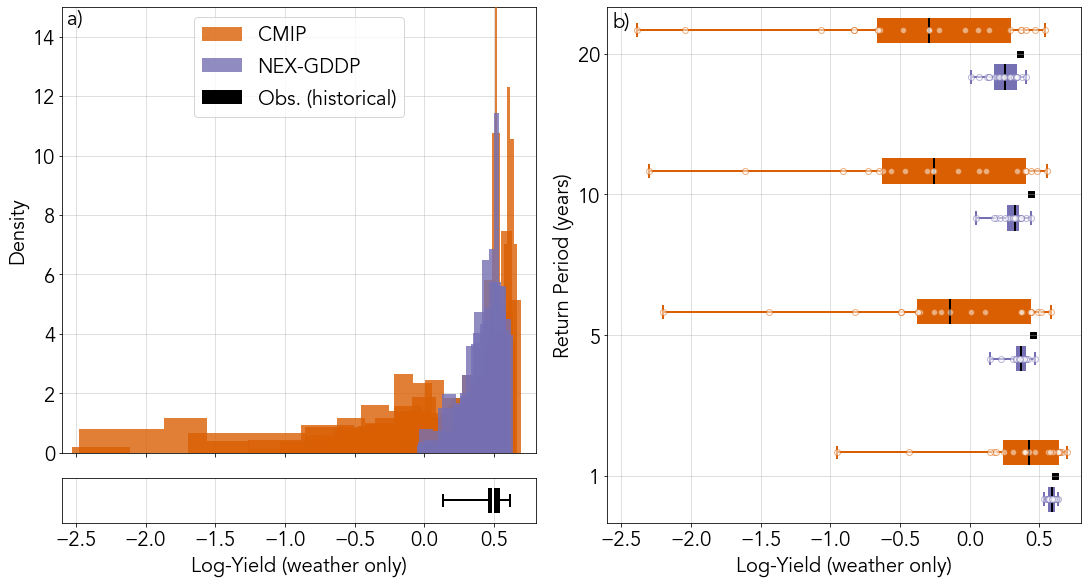

In [38]:
# Figure 4
fig = plt.figure(constrained_layout=True, figsize=(15,8))
gs = GridSpec(2, 2, figure=fig, height_ratios=[10,1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

###############
# Plot style
###############
model_lw = 1.5
model_alpha = 0.8
nex_col = '#7570b3'
cmip_col = '#d95f02'

# Models
ax=ax1
# Legend
ax.hist(cmip_weather_weighted[cmip_models[0]].query('year <= 2030 and year <= 2059')['weather'], lw=model_lw, bins='fd', color=cmip_col, alpha=model_alpha, label='CMIP', density=True, zorder=10)
ax.hist(nex_weather_weighted[nex_models[0]].query('year <= 2030 and year <= 2059')['weather'], lw=model_lw, bins='fd', color=nex_col, alpha=model_alpha, label='NEX-GDDP', density=True, zorder=10)
ax.hist([100], lw=model_lw, color='black', label='Obs. (historical)')
ax.set_xlim([-2.6, 0.8])
ax.set_xticklabels('')
ax.legend(loc = 'upper center')

# CMIP
for model in cmip_models[1:]:
    ax.hist(cmip_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'], lw=model_lw, bins='fd', color=cmip_col, alpha=model_alpha, label=None, density=True, zorder=10)

# NEX
for model in nex_models[1:]:
    ax.hist(nex_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'], lw=model_lw, bins='fd', color=nex_col, alpha=model_alpha, label=None, density=True, zorder=10)

ax.set_ylim([0,15])
ax.grid(alpha=0.5, zorder=0)
ax.set_ylabel('Density')
ax.text(0.01, 0.96, 'a)', transform=ax.transAxes)

# Obs
ax=ax2
obs_bxplt = ax.boxplot(gmfd_weather_weighted['weather'],
           vert=False,
           patch_artist=True,
           medianprops=dict(linewidth=2, color='white'),
           boxprops=dict(linewidth=2, color='black'),
           whiskerprops=dict(linewidth=2, color='black'),
           capprops=dict(linewidth=2, color='black'),
           widths=0.5, whis=(0,100), zorder=10)

for patch in obs_bxplt['boxes']:
        patch.set_facecolor('black')
        
ax.set_yticks([])
ax.set_xlabel('Log-Yield (weather only)')
ax.set_xlim([-2.6, 0.8])
ax.grid(alpha=0.5, zorder=0)

# Return period analysis
# NEX
ax=ax3
nex_bxplt = ax.boxplot(nex_ret_vals,
                       positions=[1,4,7,10],
                       patch_artist=True,
                       medianprops=dict(linewidth=2, color='black'),
                       boxprops=dict(linewidth=2, color=nex_col),
                       whiskerprops=dict(linewidth=2, color=nex_col),
                       capprops=dict(linewidth=2, color=nex_col),
                       showfliers=False,
                       whis=(0,100),
                       zorder=10,
                       vert=False)

for patch in nex_bxplt['boxes']:
        patch.set_facecolor(nex_col)
        
ax.scatter(nex_ret_vals, [[i for model in nex_models] for i in [1,4,7,10]], edgecolor=nex_col, facecolor='white', zorder=20, alpha=0.5)

# CMIP
cmip_bxplt = ax.boxplot(cmip_ret_vals,
                        positions=[2,5,8,11],
                        patch_artist=True,
                        medianprops=dict(linewidth=2, color='black'),
                        boxprops=dict(linewidth=2, color=cmip_col),
                        whiskerprops=dict(linewidth=2, color=cmip_col),
                        capprops=dict(linewidth=2, color=cmip_col),
                        showfliers=False,
                        whis=(0,100),
                        vert=False,
                        zorder=10)

ax.scatter(cmip_ret_vals, [[i for model in cmip_models] for i in [2,5,8,11]], edgecolor=cmip_col, facecolor='white', zorder=20, alpha=0.5)

for patch in cmip_bxplt['boxes']:
        patch.set_facecolor(cmip_col)

ax.set_yticks([1.5, 4.5, 7.5, 10.5])
ax.set_yticklabels(['1', '5', '10', '20'])
ax.set_ylabel('Return Period (years)')
ax.set_xlabel('Log-Yield (weather only)')
ax.grid(alpha=0.5)
ax.set_xlim([-2.6, 0.8])

# Obs
ax.scatter([gmfd_weather_weighted['weather'].quantile(q) for q in quantiles], [1.5, 4.5, 7.5, 10.5], color='black', marker='s')

ax.text(0.01, 0.96, 'b)', transform=ax.transAxes)

plt.savefig('../../figs/new/Figure4.pdf')
# plt.show()

# Supplementary plots

## Degree day only model (GDD, EDD)

In [39]:
def get_weather(x):
    return x['gdd']*beta_gdd + x['edd']*beta_edd

In [40]:
coef = pd.read_csv('../../data/yield/degreedays_only_coeffs+95.csv', index_col=0)
beta_gdd = coef.loc['gdd']['coeff']
beta_edd = coef.loc['edd']['coeff']

In [41]:
# Read in GMFD data
gmfd = pd.read_csv('../../data/yield/baseline_model_gmfd_historical.csv')
gmfd["fips"] = gmfd["fips"].astype(str).str.zfill(5)
gmfd['prcp2'] = gmfd['prcp']**2
gmfd['weather'] = gmfd.apply(get_weather, axis=1)

yield_fips = gmfd['fips'].unique() # Only take fips codes
#### Note that the regression coefficients from R are only valid for counties with USDA records n>25 (as we chose), 
#### so we subset to these counties for the yield analysis.

In [42]:
# Read in NEX models
nex_models = !ls ../../data/climate/NEX-GDDP/hist
nex = {model.replace("agvar_historical_r1i1p1_","").replace(".csv","") : pd.read_csv("../../data/climate/NEX-GDDP/hist/" + model) for model in nex_models}
nex_models = [model.replace("agvar_historical_r1i1p1_","").replace(".csv","") for model in nex_models]

# NEX weather
for model in nex_models:
    tmp = nex[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    nex[model] = tmp

In [43]:
# Read in CMIP models
cmip_models = !ls ../../data/climate/CMIP
cmip = {model.replace("agvar_","").replace("_historical","").replace(".csv","") : pd.read_csv("../../data/climate/CMIP/" + model) for model in cmip_models}
cmip_models = [model.replace("agvar_","").replace("_historical","").replace(".csv","") for model in cmip_models]

# CMIP weather
for model in cmip_models:
    tmp = cmip[model].query('year < 2006').copy()
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    cmip[model] = tmp

In [44]:
# Construct national weights (total production by weighted sum of counties) (only 1956-2005)
weights = pd.read_csv('../../data/usda/maize_county_yield_area.csv').filter(["fips", "year", "area","yield"])
weights = weights.query('year >= 1956 and year <= 2005')
weights['fips'] = weights['fips'].astype(str).str.zfill(5)
weights.sort_values(by = ['fips', 'year'], inplace = True)
weights.set_index(['fips', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["fips","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['fips','year']).sort_index()
weights = weights.filter(['national_weight'])

In [45]:
# Weight by production

# NEX
nex_weather_weighted = {}
for model in nex_models:
    tmp = nex[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    nex_weather_weighted[model] = tmp
    
# CMIP
cmip_weather_weighted = {}
for model in cmip_models:
    tmp = cmip[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    cmip_weather_weighted[model] = tmp
    
# GMFD
gmfd_weather_weighted = pd.merge(gmfd.drop(columns='state'), weights.reset_index(), on = ['fips','year'], how = 'inner')
for col in gmfd_weather_weighted.columns[2:-1]:
    gmfd_weather_weighted[col] = gmfd_weather_weighted[col] * gmfd_weather_weighted['national_weight']
gmfd_weather_weighted = gmfd_weather_weighted.groupby(['year']).sum()
gmfd_weather_weighted = gmfd_weather_weighted.apply(lambda x: x/x['national_weight'], axis=1)
gmfd_weather_weighted.drop(columns='national_weight', inplace=True)

In [46]:
# NEX
nex_mean_error = [(nex_weather_weighted[model]['weather'].mean() - gmfd_weather_weighted['weather'].mean()) / np.abs(gmfd_weather_weighted['weather'].mean()) * 100 for model in nex_models]
nex_sd_error = [(nex_weather_weighted[model]['weather'].std() - gmfd_weather_weighted['weather'].std()) / np.abs(gmfd_weather_weighted['weather'].std()) * 100 for model in nex_models]
nex_q10_error = [(nex_weather_weighted[model]['weather'].quantile(q=0.1) - gmfd_weather_weighted['weather'].quantile(q=0.1)) / np.abs(gmfd_weather_weighted['weather'].quantile(q=0.1)) * 100 for model in nex_models]
nex_min_error = [(nex_weather_weighted[model]['weather'].min() - gmfd_weather_weighted['weather'].min()) / np.abs(gmfd_weather_weighted['weather'].min()) * 100 for model in nex_models]

# CMIP
cmip_mean_error = [(cmip_weather_weighted[model]['weather'].mean() - gmfd_weather_weighted['weather'].mean()) / np.abs(gmfd_weather_weighted['weather'].mean()) * 100 for model in cmip_models]
cmip_sd_error = [(cmip_weather_weighted[model]['weather'].std() - gmfd_weather_weighted['weather'].std()) / np.abs(gmfd_weather_weighted['weather'].std()) * 100 for model in cmip_models]
cmip_q10_error = [(cmip_weather_weighted[model]['weather'].quantile(q=0.1) - gmfd_weather_weighted['weather'].quantile(q=0.1)) / np.abs(gmfd_weather_weighted['weather'].quantile(q=0.1)) * 100 for model in cmip_models]
cmip_min_error = [(cmip_weather_weighted[model]['weather'].min() - gmfd_weather_weighted['weather'].min()) / np.abs(gmfd_weather_weighted['weather'].min()) * 100 for model in cmip_models]

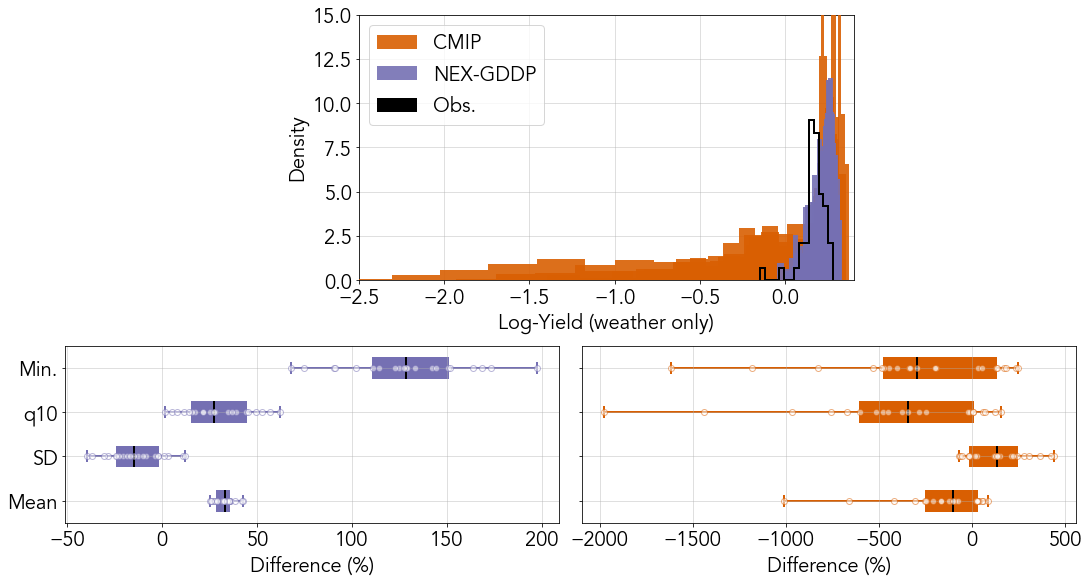

In [47]:
# All plot
fig = plt.figure(constrained_layout=True, figsize=(15,8))
gs = GridSpec(2, 4, figure=fig, height_ratios=[1.5,1], wspace=0.05)
ax1 = fig.add_subplot(gs[0, 1:-1])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:])

###############
# Plot style
###############
model_lw = 1.5
obs_lw = 2
model_alpha = 0.9
nex_col = '#7570b3'
cmip_col = '#d95f02'


######## Hist plot
ax=ax1

# Legend
ax.hist(cmip_weather_weighted[cmip_models[0]]['weather'], lw=model_lw, bins='fd', color=cmip_col, alpha=model_alpha, label='CMIP', density=True, zorder=10)
ax.hist(nex_weather_weighted[nex_models[0]]['weather'], lw=model_lw, bins='fd', color=nex_col, alpha=model_alpha, label='NEX-GDDP', density=True, zorder=10)
ax.hist([100], lw=model_lw, color='black', label='Obs.')
ax.set_xlim([-2.5, 0.4])
ax.legend()

# CMIP
for model in cmip_models[1:]:
    ax.hist(cmip_weather_weighted[model]['weather'], lw=model_lw, bins='fd', color=cmip_col, alpha=model_alpha, label=None, density=True, zorder=10)

# NEX
for model in nex_models[1:]:
    ax.hist(nex_weather_weighted[model]['weather'], lw=model_lw, bins='fd', color=nex_col, alpha=model_alpha, label=None, density=True, zorder=10)

# GMFD
ax.hist(gmfd_weather_weighted['weather'], lw=obs_lw, bins='fd', histtype='step', color='black', label=None, density=True, zorder=10)

ax.set_ylim([0,15])
ax.grid(alpha=0.5, zorder=1)
ax.set_ylabel('Density')
ax.set_xlabel('Log-Yield (weather only)')

########## Errors plot

# NEX
ax=ax2
nex_bxplt = ax.boxplot([nex_mean_error, nex_sd_error, nex_q10_error, nex_min_error],
                       positions=[1,2,3,4],
                       patch_artist=True,
                       medianprops=dict(linewidth=2, color='black'),
                       boxprops=dict(linewidth=2, color=nex_col),
                       whiskerprops=dict(linewidth=2, color=nex_col),
                       capprops=dict(linewidth=2, color=nex_col),
                       showfliers=False,
                       whis=(0,100),
                       vert=False,
                       zorder=1)

for patch in nex_bxplt['boxes']:
        patch.set_facecolor(nex_col)
        
ax.scatter(nex_min_error, [4 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(nex_q10_error, [3 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(nex_sd_error, [2 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(nex_mean_error, [1 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
        
ax.set_yticks([1,2,3,4])
ax.set_yticklabels(['Mean', 'SD', 'q10', 'Min.'])
ax.set_xlabel('Difference (%)')
ax.grid(alpha=0.5)

# CMIP
ax=ax3
cmip_bxplt = ax.boxplot([cmip_mean_error, cmip_sd_error, cmip_q10_error, cmip_min_error],
                        positions=[1,2,3,4],
                        patch_artist=True,
                        medianprops=dict(linewidth=2, color='black'),
                        boxprops=dict(linewidth=2, color=cmip_col),
                        whiskerprops=dict(linewidth=2, color=cmip_col),
                        capprops=dict(linewidth=2, color=cmip_col),
                        showfliers=False,
                        whis=(0,100),
                        vert=False,
                        zorder=1)

for patch in cmip_bxplt['boxes']:
        patch.set_facecolor(cmip_col)
        
ax.scatter(cmip_min_error, [4 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(cmip_q10_error, [3 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(cmip_sd_error, [2 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(cmip_mean_error, [1 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)

ax.set_xlabel('Difference (%)')
ax.set_yticklabels(['', '', '', ''])
ax.grid(alpha=0.5)

plt.savefig('../../figs/new/SIfig_GDD+EDD_model_national_eval.pdf')
# plt.show()

## All other models

In [48]:
def get_weather(x, coeff):
    tmp = [x[var] * coeff.loc[var]['coeff'] for var in coeff.T.columns]
    return np.sum(tmp, axis=0)

In [49]:
# Models correspond to same order as table
coef1 = pd.read_csv('../../data/yield/degreedays_only_coeffs+95.csv', index_col=0)
coef2 = pd.read_csv('../../data/yield/Tavg_only_coeffs+95.csv', index_col=0)
coef3 = pd.read_csv('../../data/yield/Tmin_only_coeffs+95.csv', index_col=0)
coef4 = pd.read_csv('../../data/yield/Tmax_only_coeffs+95.csv', index_col=0)
coef5 = pd.read_csv('../../data/yield/baseline_coeffs+95.csv', index_col=0)
coef6 = pd.read_csv('../../data/yield/Tavg_prcp_coeffs+95.csv', index_col=0)
coef7 = pd.read_csv('../../data/yield/Tmin_prcp_coeffs+95.csv', index_col=0)
coef8 = pd.read_csv('../../data/yield/Tmax_prcp_coeffs+95.csv', index_col=0)

In [50]:
# Read in GMFD data
gmfd_ddp = pd.read_csv('../../data/yield/baseline_model_gmfd_historical.csv')
gmfd_tavg = pd.read_csv('../../data/climate/rawT_all/GMFD/gmfd_tavg_hist.csv')
gmfd_tmin = pd.read_csv('../../data/climate/rawT_all/GMFD/gmfd_tmin_hist.csv')
gmfd_tmax = pd.read_csv('../../data/climate/rawT_all/GMFD/gmfd_tmax_hist.csv')
gmfd = pd.merge(pd.merge(pd.merge(gmfd_ddp, gmfd_tavg), gmfd_tmin), gmfd_tmax)
gmfd['tavg2'] = gmfd['tavg']**2
gmfd['tmin2'] = gmfd['tmin']**2
gmfd['tmax2'] = gmfd['tmax']**2
gmfd['prcp2'] = gmfd['prcp']**2

gmfd["fips"] = gmfd["fips"].astype(str).str.zfill(5)

gmfd['weather_1'] = get_weather(gmfd, coef1)
gmfd['weather_2'] = get_weather(gmfd, coef2)
gmfd['weather_3'] = get_weather(gmfd, coef3)
gmfd['weather_4'] = get_weather(gmfd, coef4)
gmfd['weather_5'] = get_weather(gmfd, coef5)
gmfd['weather_6'] = get_weather(gmfd, coef6)
gmfd['weather_7'] = get_weather(gmfd, coef7)
gmfd['weather_8'] = get_weather(gmfd, coef8)

yield_fips = gmfd['fips'].unique() # Only take fips codes
#### Note that the regression coefficients from R are only valid for counties with USDA records n>25 (as we chose), 
#### so we subset to these counties for the yield analysis.

In [51]:
# Read in NEX models
nex_models = !ls ../../data/climate/NEX-GDDP/hist
nex_models = [model.replace("agvar_historical_r1i1p1_","").replace(".csv","") for model in nex_models]
nex = {}
for model in nex_models:
    tmp_ddp = pd.read_csv('../../data/climate/NEX-GDDP/hist/agvar_historical_r1i1p1_' + model + '.csv')
    tmp_tavg = pd.read_csv('../../data/climate/rawT_all/NEX-GDDP/tavg/tavg_hist_' + model + '.csv').rename(columns = {'tasavg':'tavg'})
    tmp_tmin = pd.read_csv('../../data/climate/rawT_all/NEX-GDDP/tmin/tmin_hist_' + model + '.csv').rename(columns = {'tasmin':'tmin'})
    tmp_tmax = pd.read_csv('../../data/climate/rawT_all/NEX-GDDP/tmax/tmax_hist_' + model + '.csv').rename(columns = {'tasmax':'tmax'})
    tmp = pd.merge(pd.merge(pd.merge(tmp_ddp, tmp_tavg), tmp_tmin), tmp_tmax)
    
    nex.update({model : tmp})

# NEX weather
for model in nex_models:
    tmp = nex[model]
    
    tmp['prcp2'] = tmp['prcp']**2
    tmp['tavg2'] = tmp['tavg']**2
    tmp['tmin2'] = tmp['tmin']**2
    tmp['tmax2'] = tmp['tmax']**2
    
    tmp['weather_1'] = get_weather(tmp, coef1)
    tmp['weather_2'] = get_weather(tmp, coef2)
    tmp['weather_3'] = get_weather(tmp, coef3)
    tmp['weather_4'] = get_weather(tmp, coef4)
    tmp['weather_5'] = get_weather(tmp, coef5)
    tmp['weather_6'] = get_weather(tmp, coef6)
    tmp['weather_7'] = get_weather(tmp, coef7)
    tmp['weather_8'] = get_weather(tmp, coef8)

    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    nex[model] = tmp

In [52]:
# Read in CMIP models
cmip_models = !ls ../../data/climate/CMIP
cmip_models = [model.replace("agvar_","").replace("historical+rcp85","").replace(".csv","") for model in cmip_models]
cmip = {}
for model in cmip_models:
    tmp_ddp = pd.read_csv('../../data/climate/CMIP/agvar_' + model + 'historical+rcp85.csv')
    tmp_tavg = pd.read_csv('../../data/climate/rawT_all/CMIP/tavg/tavg_hist_' + model[:-1] + '.csv').rename(columns = {'tasavg':'tavg'})
    tmp_tmin = pd.read_csv('../../data/climate/rawT_all/CMIP/tmin/tmin_hist_' + model[:-1] + '.csv').rename(columns = {'tasmin':'tmin'})
    tmp_tmax = pd.read_csv('../../data/climate/rawT_all/CMIP/tmax/tmax_hist_' + model[:-1] + '.csv').rename(columns = {'tasmax':'tmax'})
    tmp = pd.merge(pd.merge(pd.merge(tmp_ddp, tmp_tavg), tmp_tmin), tmp_tmax)
    
    cmip.update({model[:-1] : tmp})

cmip_models = [model[:-1] for model in cmip_models]
# CMIP weather
for model in cmip_models:
    tmp = cmip[model]
    
    tmp['prcp2'] = tmp['prcp']**2
    tmp['tavg2'] = tmp['tavg']**2
    tmp['tmin2'] = tmp['tmin']**2
    tmp['tmax2'] = tmp['tmax']**2
    
    tmp['weather_1'] = get_weather(tmp, coef1)
    tmp['weather_2'] = get_weather(tmp, coef2)
    tmp['weather_3'] = get_weather(tmp, coef3)
    tmp['weather_4'] = get_weather(tmp, coef4)
    tmp['weather_5'] = get_weather(tmp, coef5)
    tmp['weather_6'] = get_weather(tmp, coef6)
    tmp['weather_7'] = get_weather(tmp, coef7)
    tmp['weather_8'] = get_weather(tmp, coef8)

    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    cmip[model] = tmp

In [53]:
# Construct national weights (total production by weighted sum of counties) (only 1956-2005)
weights = pd.read_csv('../../data/usda/maize_county_yield_area.csv').filter(["fips", "year", "area","yield"])
weights = weights.query('year >= 1956 and year <= 2005')
weights['fips'] = weights['fips'].astype(str).str.zfill(5)
weights.sort_values(by = ['fips', 'year'], inplace = True)
weights.set_index(['fips', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["fips","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['fips','year']).sort_index()
weights = weights.filter(['national_weight'])

In [54]:
# Weight by production

# NEX
nex_weather_weighted = {}
for model in nex_models:
    tmp = nex[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    nex_weather_weighted[model] = tmp
    
# CMIP
cmip_weather_weighted = {}
for model in cmip_models:
    tmp = cmip[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    cmip_weather_weighted[model] = tmp
    
# GMFD
gmfd_weather_weighted = pd.merge(gmfd.drop(columns='state'), weights.reset_index(), on = ['fips','year'], how = 'inner')
for col in gmfd_weather_weighted.columns[2:-1]:
    gmfd_weather_weighted[col] = gmfd_weather_weighted[col] * gmfd_weather_weighted['national_weight']
gmfd_weather_weighted = gmfd_weather_weighted.groupby(['year']).sum()
gmfd_weather_weighted = gmfd_weather_weighted.apply(lambda x: x/x['national_weight'], axis=1)
gmfd_weather_weighted.drop(columns='national_weight', inplace=True)

In [55]:
# NEX
nex_mean_error = {}
nex_sd_error = {}
nex_q10_error = {}
nex_min_error = {}
for i in range(1,9):
    nex_mean_error.update({str(i) : [(nex_weather_weighted[model]['weather_' + str(i)].mean() - gmfd_weather_weighted['weather_' + str(i)].mean()) / np.abs(gmfd_weather_weighted['weather_' + str(i)].mean()) * 100 for model in nex_models]})
    nex_sd_error.update({str(i) : [(nex_weather_weighted[model]['weather_' + str(i)].std() - gmfd_weather_weighted['weather_' + str(i)].std()) / np.abs(gmfd_weather_weighted['weather_' + str(i)].std()) * 100 for model in nex_models]})
    nex_q10_error.update({str(i) : [(nex_weather_weighted[model]['weather_' + str(i)].quantile(q=0.1) - gmfd_weather_weighted['weather_' + str(i)].quantile(q=0.1)) / np.abs(gmfd_weather_weighted['weather_' + str(i)].quantile(q=0.1)) * 100 for model in nex_models]})
    nex_min_error.update({str(i) : [(nex_weather_weighted[model]['weather_' + str(i)].min() - gmfd_weather_weighted['weather_' + str(i)].min()) / np.abs(gmfd_weather_weighted['weather_' + str(i)].min()) * 100 for model in nex_models]})
    
# CMIP
cmip_mean_error = {}
cmip_sd_error = {}
cmip_q10_error = {}
cmip_min_error = {}
for i in range(1,9):
    cmip_mean_error.update({str(i) : [(cmip_weather_weighted[model]['weather_' + str(i)].mean() - gmfd_weather_weighted['weather_' + str(i)].mean()) / np.abs(gmfd_weather_weighted['weather_' + str(i)].mean()) * 100 for model in cmip_models]})
    cmip_sd_error.update({str(i) : [(cmip_weather_weighted[model]['weather_' + str(i)].std() - gmfd_weather_weighted['weather_' + str(i)].std()) / np.abs(gmfd_weather_weighted['weather_' + str(i)].std()) * 100 for model in cmip_models]})
    cmip_q10_error.update({str(i) : [(cmip_weather_weighted[model]['weather_' + str(i)].quantile(q=0.1) - gmfd_weather_weighted['weather_' + str(i)].quantile(q=0.1)) / np.abs(gmfd_weather_weighted['weather_' + str(i)].quantile(q=0.1)) * 100 for model in cmip_models]})
    cmip_min_error.update({str(i) : [(cmip_weather_weighted[model]['weather_' + str(i)].min() - gmfd_weather_weighted['weather_' + str(i)].min()) / np.abs(gmfd_weather_weighted['weather_' + str(i)].min()) * 100 for model in cmip_models]})

In [56]:
model_desc = ['GDD + EDD', 'Tavg', 'Tmin', 'Tmax', 'GDD + EDD + P', 'Tavg + P', 'Tmin + P', 'Tmax + P']

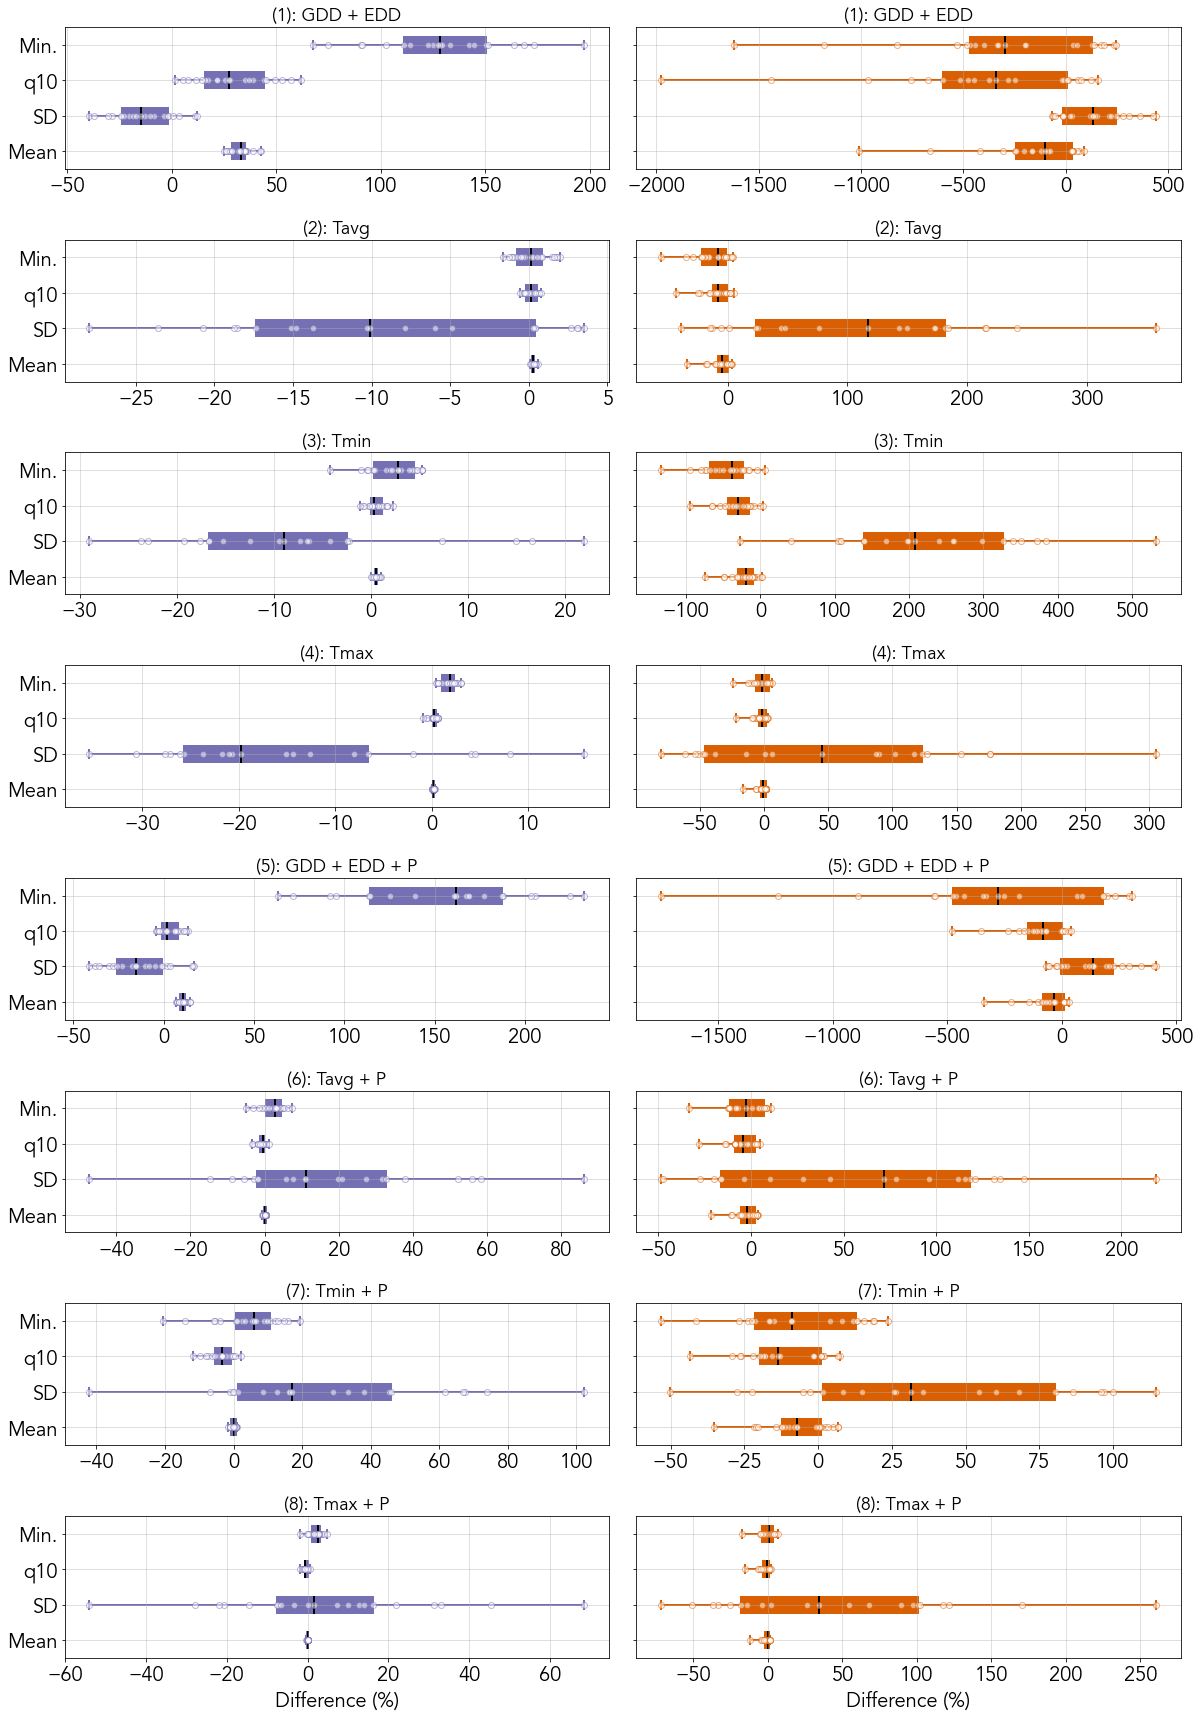

In [57]:
# All plot
fig, axs = plt.subplots(8,2, figsize=(20,30), gridspec_kw={'wspace':0.05, 'hspace':0.5})
axs=axs.flatten()

###############
# Plot style
###############
model_lw = 1.5
obs_lw = 2
model_alpha = 0.9
nex_col = '#7570b3'
cmip_col = '#d95f02'

for i in range(8):
    # NEX
    ax=axs[2*i]
    nex_bxplt = ax.boxplot([nex_mean_error[str(i+1)], nex_sd_error[str(i+1)], nex_q10_error[str(i+1)], nex_min_error[str(i+1)]],
                           positions=[1,2,3,4],
                           patch_artist=True,
                           medianprops=dict(linewidth=2, color='black'),
                           boxprops=dict(linewidth=2, color=nex_col),
                           whiskerprops=dict(linewidth=2, color=nex_col),
                           capprops=dict(linewidth=2, color=nex_col),
                           showfliers=False,
                           whis=(0,100),
                           vert=False,
                           zorder=1)
    
    for patch in nex_bxplt['boxes']:
            patch.set_facecolor(nex_col)
            
    ax.scatter(nex_min_error[str(i+1)], [4 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
    ax.scatter(nex_q10_error[str(i+1)], [3 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
    ax.scatter(nex_sd_error[str(i+1)], [2 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
    ax.scatter(nex_mean_error[str(i+1)], [1 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
            
    ax.set_yticks([1,2,3,4])
    ax.set_yticklabels(['Mean', 'SD', 'q10', 'Min.'])
    if i == 7:
        ax.set_xlabel('Difference (%)')
    ax.grid(alpha=0.5)
    ax.set_title('(' + str(i+1) + '): ' + model_desc[i], size=18)
    
    # CMIP
    ax=axs[2*i + 1]
    cmip_bxplt = ax.boxplot([cmip_mean_error[str(i+1)], cmip_sd_error[str(i+1)], cmip_q10_error[str(i+1)], cmip_min_error[str(i+1)]],
                            positions=[1,2,3,4],
                            patch_artist=True,
                            medianprops=dict(linewidth=2, color='black'),
                            boxprops=dict(linewidth=2, color=cmip_col),
                            whiskerprops=dict(linewidth=2, color=cmip_col),
                            capprops=dict(linewidth=2, color=cmip_col),
                            showfliers=False,
                            whis=(0,100),
                            vert=False,
                            zorder=1)
    
    for patch in cmip_bxplt['boxes']:
            patch.set_facecolor(cmip_col)
            
    ax.scatter(cmip_min_error[str(i+1)], [4 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
    ax.scatter(cmip_q10_error[str(i+1)], [3 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
    ax.scatter(cmip_sd_error[str(i+1)], [2 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
    ax.scatter(cmip_mean_error[str(i+1)], [1 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
    
    if i==7:
        ax.set_xlabel('Difference (%)')
    ax.set_yticklabels(['', '', '', ''])
    ax.grid(alpha=0.5)
    ax.set_title('(' + str(i+1) + '): ' + model_desc[i], size=18)
    
plt.savefig('../../figs/new/SIfig_all_models_national_eval.pdf')
# plt.show()

In [58]:
# KS for all
from scipy.stats import ks_2samp

nex_ks_stat = {}
nex_ks_p = {}
cmip_ks_stat = {}
cmip_ks_p = {}
for i in range(1,9):
    nex_ks_stat.update({str(i) : [ks_2samp(nex_weather_weighted[model]['weather_' + str(i)], gmfd_weather_weighted['weather_' + str(i)])[0] for model in nex_models]})
    nex_ks_p.update({str(i) : [ks_2samp(nex_weather_weighted[model]['weather_' + str(i)], gmfd_weather_weighted['weather_' + str(i)])[1] for model in nex_models]})
    cmip_ks_stat.update({str(i) : [ks_2samp(cmip_weather_weighted[model]['weather_' + str(i)], gmfd_weather_weighted['weather_' + str(i)])[0] for model in cmip_models]})
    cmip_ks_p.update({str(i) : [ks_2samp(cmip_weather_weighted[model]['weather_' + str(i)], gmfd_weather_weighted['weather_' + str(i)])[1] for model in cmip_models]})

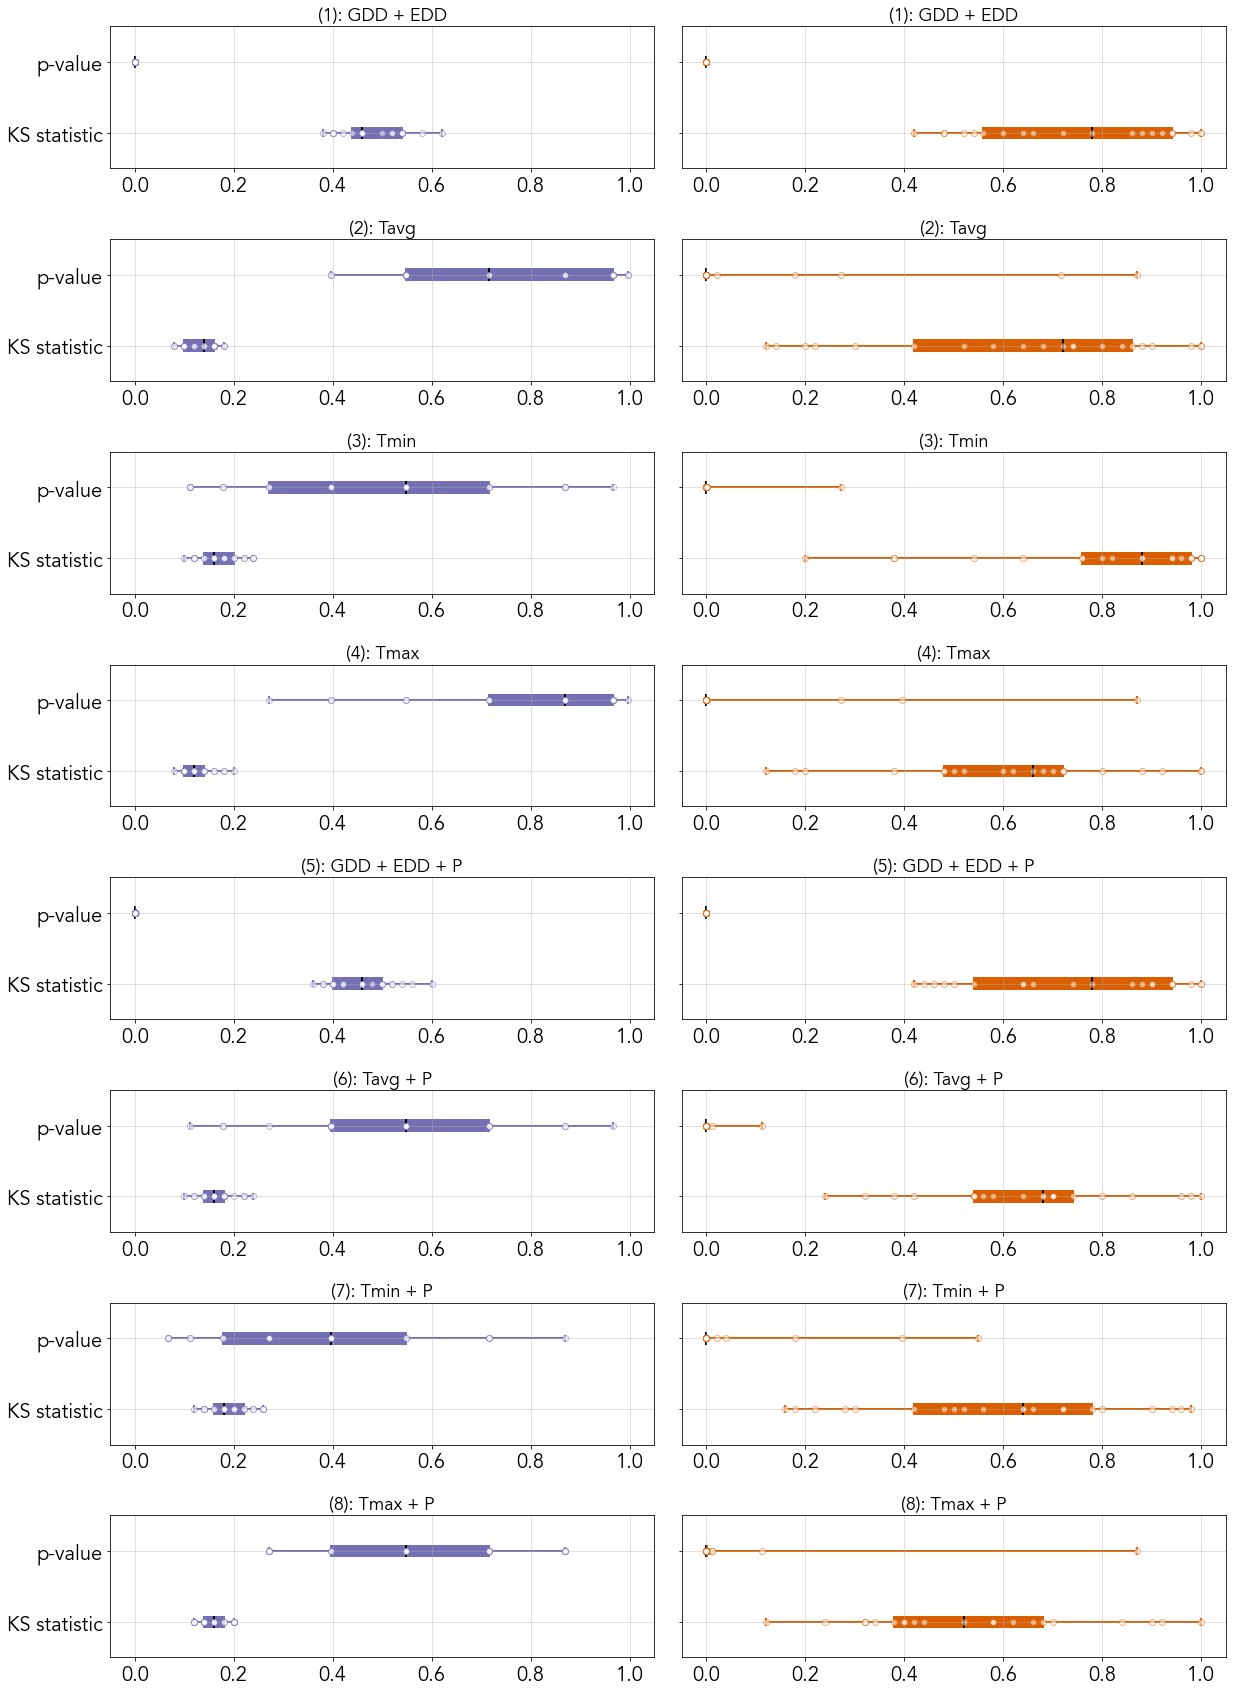

In [59]:
# All plot (KS statistic)
fig, axs = plt.subplots(8,2, figsize=(20,30), gridspec_kw={'wspace':0.05, 'hspace':0.5})
axs=axs.flatten()

###############
# Plot style
###############
model_lw = 1.5
obs_lw = 2
model_alpha = 0.9
nex_col = '#7570b3'
cmip_col = '#d95f02'

for i in range(8):
    # NEX
    ax=axs[2*i]
    nex_bxplt = ax.boxplot([nex_ks_stat[str(i+1)], nex_ks_p[str(i+1)]],
                           positions=[1,2],
                           patch_artist=True,
                           medianprops=dict(linewidth=2, color='black'),
                           boxprops=dict(linewidth=2, color=nex_col),
                           whiskerprops=dict(linewidth=2, color=nex_col),
                           capprops=dict(linewidth=2, color=nex_col),
                           showfliers=False,
                           whis=(0,100),
                           vert=False,
                           zorder=1)

    for patch in nex_bxplt['boxes']:
            patch.set_facecolor(nex_col)
            
    ax.scatter(nex_ks_stat[str(i+1)], [1 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
    ax.scatter(nex_ks_p[str(i+1)], [2 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
            
    ax.set_yticks([1,2])
    ax.set_yticklabels(['KS statistic', 'p-value'])
    ax.grid(alpha=0.5)
    ax.set_xlim([-0.05,1.05])
    ax.set_title('(' + str(i+1) + '): ' + model_desc[i], size=18)
    
    # CMIP
    ax=axs[2*i + 1]
    cmip_bxplt = ax.boxplot([cmip_ks_stat[str(i+1)], cmip_ks_p[str(i+1)]],
                            positions=[1,2],
                            patch_artist=True,
                            medianprops=dict(linewidth=2, color='black'),
                            boxprops=dict(linewidth=2, color=cmip_col),
                            whiskerprops=dict(linewidth=2, color=cmip_col),
                            capprops=dict(linewidth=2, color=cmip_col),
                            showfliers=False,
                            whis=(0,100),
                            vert=False,
                            zorder=1)
    
    for patch in cmip_bxplt['boxes']:
            patch.set_facecolor(cmip_col)
            
    ax.scatter(cmip_ks_stat[str(i+1)], [1 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
    ax.scatter(cmip_ks_p[str(i+1)], [2 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
    
    ax.set_yticklabels(['', ''])
    ax.grid(alpha=0.5)
    ax.set_xlim([-0.05,1.05])
    ax.set_title('(' + str(i+1) + '): ' + model_desc[i], size=18)
    
# plt.savefig('../../figs/new/SIfig_all_models_national_KS.pdf')
plt.show()

## Joint T,P distribution evaluation

In [61]:
def get_weather(x):
    return x['gdd']*beta_gdd + x['edd']*beta_edd + x['prcp']*beta_prcp + x['prcp2']*beta_prcp2

In [62]:
coef = pd.read_csv('../../data/yield/baseline_coeffs+95.csv', index_col=0)
beta_gdd = coef.loc['gdd']['coeff']
beta_edd = coef.loc['edd']['coeff']
beta_prcp = coef.loc['prcp']['coeff']
beta_prcp2 = coef.loc['prcp2']['coeff']

In [63]:
# Read in GMFD data
gmfd = pd.read_csv('../../data/yield/baseline_model_gmfd_historical.csv')
gmfd["fips"] = gmfd["fips"].astype(str).str.zfill(5)
gmfd['prcp2'] = gmfd['prcp']**2
gmfd['weather'] = gmfd.apply(get_weather, axis=1)

yield_fips = gmfd['fips'].unique() # Only take fips codes
#### Note that the regression coefficients from R are only valid for counties with USDA records n>25 (as we chose), 
#### so we subset to these counties for the yield analysis.

In [64]:
# Read in NEX models
nex_models = !ls ../../data/climate/NEX-GDDP/hist
nex = {model.replace("agvar_historical_r1i1p1_","").replace(".csv","") : pd.read_csv("../../data/climate/NEX-GDDP/hist/" + model) for model in nex_models}
nex_models = [model.replace("agvar_historical_r1i1p1_","").replace(".csv","") for model in nex_models]

# NEX weather
for model in nex_models:
    tmp = nex[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    nex[model] = tmp

In [65]:
# Read in CMIP models
cmip_models = !ls ../../data/climate/CMIP
cmip = {model.replace("agvar_","").replace("_historical","").replace(".csv","") : pd.read_csv("../../data/climate/CMIP/" + model) for model in cmip_models}
cmip_models = [model.replace("agvar_","").replace("_historical","").replace(".csv","") for model in cmip_models]

# CMIP weather
for model in cmip_models:
    tmp = cmip[model].query('year < 2006').copy()
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp.set_index(['fips', 'year'], inplace = True)
    tmp = tmp.loc[yield_fips]
    cmip[model] = tmp

In [66]:
# Construct national weights (total production by weighted sum of counties) (only 1956-2005)
weights = pd.read_csv('../../data/usda/maize_county_yield_area.csv').filter(["fips", "year", "area","yield"])
weights = weights.query('year >= 1956 and year <= 2005')
weights['fips'] = weights['fips'].astype(str).str.zfill(5)
weights.sort_values(by = ['fips', 'year'], inplace = True)
weights.set_index(['fips', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["fips","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['fips','year']).sort_index()
weights = weights.filter(['national_weight'])

In [67]:
# Weight by production

# NEX
nex_weather_weighted = {}
for model in nex_models:
    tmp = nex[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    nex_weather_weighted[model] = tmp
    
# CMIP
cmip_weather_weighted = {}
for model in cmip_models:
    tmp = cmip[model].drop(columns='state')
    tmp = pd.merge(tmp.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    cmip_weather_weighted[model] = tmp
    
# GMFD
gmfd_weather_weighted = pd.merge(gmfd.drop(columns='state'), weights.reset_index(), on = ['fips','year'], how = 'inner')
for col in gmfd_weather_weighted.columns[2:-1]:
    gmfd_weather_weighted[col] = gmfd_weather_weighted[col] * gmfd_weather_weighted['national_weight']
gmfd_weather_weighted = gmfd_weather_weighted.groupby(['year']).sum()
gmfd_weather_weighted = gmfd_weather_weighted.apply(lambda x: x/x['national_weight'], axis=1)
gmfd_weather_weighted.drop(columns='national_weight', inplace=True)

In [68]:
prcp_tp = -beta_prcp / (2*beta_prcp2) # maximum (point above which precipitation negatively affects yields)

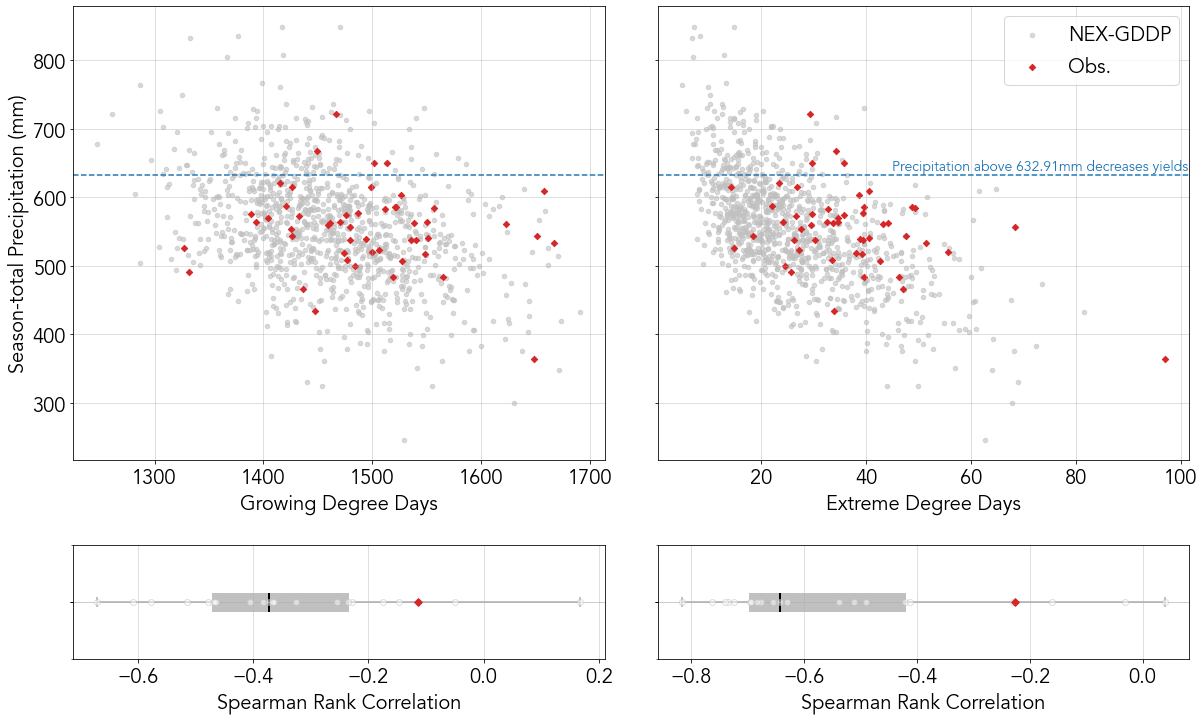

In [72]:
# NEX
fig, axs = plt.subplots(2,2, figsize=(20,12), sharey='row', gridspec_kw={'wspace':0.1, 'hspace':0.3, 'height_ratios':[4,1]})

# GDD-precip
# scatter
ax=axs[0,0]
for model in nex_models:
    nex_weather_weighted[model].plot(x='gdd', y='prcp', kind='scatter', ax=ax, color='silver', alpha=0.6)
gmfd_weather_weighted.plot(x='gdd', y='prcp', kind='scatter', ax=ax, color='tab:red', s=20, marker='D')
ax.set_ylabel('Season-total Precipitation (mm)')
ax.set_xlabel('Growing Degree Days')
ax.grid(alpha=0.5)
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
ax.hlines(prcp_tp, ax.get_xlim()[0], ax.get_xlim()[1], ls='--', color='tab:blue')

# boxplot
ax=axs[1,0]
nex_gdd_bxplt = ax.boxplot([spearmanr(nex_weather_weighted[model]['gdd'], nex_weather_weighted[model]['prcp'])[0] for model in nex_models],
                        patch_artist=True,
                        medianprops=dict(linewidth=2, color='black'),
                        boxprops=dict(linewidth=2, color='silver'),
                        whiskerprops=dict(linewidth=2, color='silver'),
                        capprops=dict(linewidth=2, color='silver'),
                        showfliers=False,
                        whis=(0,100),
                        vert=False,
                        zorder=1)
for patch in nex_gdd_bxplt['boxes']:
        patch.set_facecolor('silver')
ax.scatter([spearmanr(nex_weather_weighted[model]['gdd'], nex_weather_weighted[model]['prcp'])[0] for model in nex_models], [1 for model in nex_models], edgecolor='silver', facecolor='white', zorder=10, alpha=0.5)
ax.scatter(spearmanr(gmfd_weather_weighted['gdd'], gmfd_weather_weighted['prcp'])[0], 1, color='tab:red', marker='D', s=30, zorder=10)
ax.grid(alpha=0.5)
ax.set_yticklabels([''])
ax.set_xlabel('Spearman Rank Correlation')

# EDD-precip
# scatter
ax=axs[0,1]

nex_weather_weighted[nex_models[0]].plot(x='edd', y='prcp', kind='scatter', ax=ax, color='silver', alpha=0.6, label='NEX-GDDP')
    
for model in nex_models[1:]:
    nex_weather_weighted[model].plot(x='edd', y='prcp', kind='scatter', ax=ax, color='silver', alpha=0.6, legend=None)
gmfd_weather_weighted.plot(x='edd', y='prcp', kind='scatter', ax=ax, color='tab:red', s=20, marker='D', label='Obs.')
ax.set_xlabel('Extreme Degree Days')
ax.grid(alpha=0.5)
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
ax.hlines(prcp_tp, ax.get_xlim()[0], ax.get_xlim()[1], ls='--', color='tab:blue')
ax.text(45, 640, 'Precipitation above {0:.2f}mm decreases yields'.format(prcp_tp), color='tab:blue', size=14)

ax.legend()

# boxplot
ax=axs[1,1]
nex_edd_bxplt = ax.boxplot([spearmanr(nex_weather_weighted[model]['edd'], nex_weather_weighted[model]['prcp'])[0] for model in nex_models],
                        patch_artist=True,
                        medianprops=dict(linewidth=2, color='black'),
                        boxprops=dict(linewidth=2, color='silver'),
                        whiskerprops=dict(linewidth=2, color='silver'),
                        capprops=dict(linewidth=2, color='silver'),
                        showfliers=False,
                        whis=(0,100),
                        vert=False,
                        zorder=1)
for patch in nex_edd_bxplt['boxes']:
        patch.set_facecolor('silver')

ax.scatter([spearmanr(nex_weather_weighted[model]['edd'], nex_weather_weighted[model]['prcp'])[0] for model in nex_models], [1 for model in nex_models], edgecolor='silver', facecolor='white', zorder=10, alpha=0.5)
ax.scatter(spearmanr(gmfd_weather_weighted['edd'], gmfd_weather_weighted['prcp'])[0], 1, color='tab:red', marker='D', s=30, zorder=10)
ax.grid(alpha=0.5)
ax.set_xlabel('Spearman Rank Correlation')
ax.set_yticklabels(['',''])

# plt.show()
plt.savefig('../../figs/new/SIfig_joint_eval_NEX.pdf')

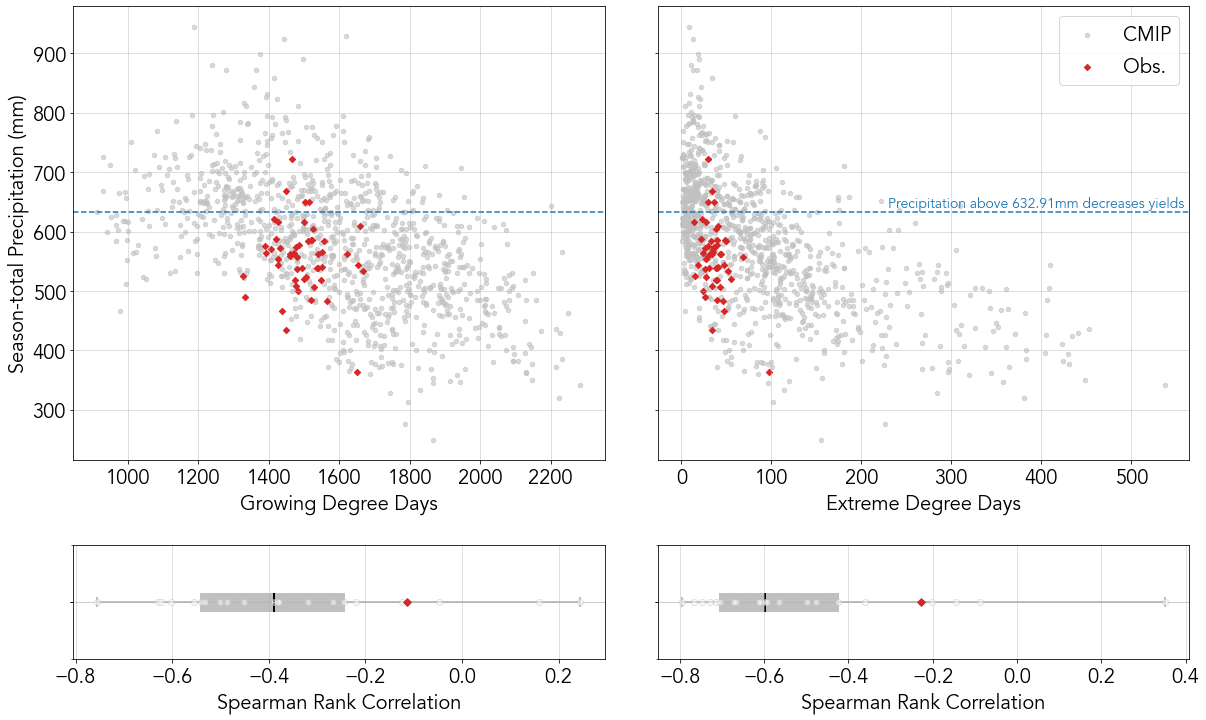

In [70]:
# CMIP
fig, axs = plt.subplots(2,2, figsize=(20,12), sharey='row', gridspec_kw={'wspace':0.1, 'hspace':0.3, 'height_ratios':[4,1]})

# GDD-precip
# scatter
ax=axs[0,0]
for model in cmip_models:
    cmip_weather_weighted[model].plot(x='gdd', y='prcp', kind='scatter', ax=ax, color='silver', alpha=0.6)
gmfd_weather_weighted.plot(x='gdd', y='prcp', kind='scatter', ax=ax, color='tab:red', s=20, marker='D')
ax.set_ylabel('Season-total Precipitation (mm)')
ax.set_xlabel('Growing Degree Days')
ax.grid(alpha=0.5)
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
ax.hlines(prcp_tp, ax.get_xlim()[0], ax.get_xlim()[1], ls='--', color='tab:blue')

# boxplot
ax=axs[1,0]
cmip_gdd_bxplt = ax.boxplot([spearmanr(cmip_weather_weighted[model]['gdd'], cmip_weather_weighted[model]['prcp'])[0] for model in cmip_models],
                        patch_artist=True,
                        medianprops=dict(linewidth=2, color='black'),
                        boxprops=dict(linewidth=2, color='silver'),
                        whiskerprops=dict(linewidth=2, color='silver'),
                        capprops=dict(linewidth=2, color='silver'),
                        showfliers=False,
                        whis=(0,100),
                        vert=False,
                        zorder=1)
for patch in cmip_gdd_bxplt['boxes']:
        patch.set_facecolor('silver')
ax.scatter([spearmanr(cmip_weather_weighted[model]['gdd'], cmip_weather_weighted[model]['prcp'])[0] for model in cmip_models], [1 for model in cmip_models], edgecolor='silver', facecolor='white', zorder=10, alpha=0.5)
ax.scatter(spearmanr(gmfd_weather_weighted['gdd'], gmfd_weather_weighted['prcp'])[0], 1, color='tab:red', marker='D', s=30, zorder=10)
ax.grid(alpha=0.5)
ax.set_yticklabels([''])
ax.set_xlabel('Spearman Rank Correlation')

# EDD-precip
# scatter
ax=axs[0,1]

cmip_weather_weighted[model].plot(x='edd', y='prcp', kind='scatter', ax=ax, color='silver', alpha=0.6, label='CMIP')
    
for model in cmip_models[1:]:
    cmip_weather_weighted[model].plot(x='edd', y='prcp', kind='scatter', ax=ax, color='silver', alpha=0.6, legend=None)
    
gmfd_weather_weighted.plot(x='edd', y='prcp', kind='scatter', ax=ax, color='tab:red', s=20, marker='D', label='Obs.')
ax.set_xlabel('Extreme Degree Days')
ax.grid(alpha=0.5)
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
ax.hlines(prcp_tp, ax.get_xlim()[0], ax.get_xlim()[1], ls='--', color='tab:blue')
ax.text(230, 640, 'Precipitation above {0:.2f}mm decreases yields'.format(prcp_tp), color='tab:blue', size=14)
ax.legend()

# boxplot
ax=axs[1,1]
cmip_edd_bxplt = ax.boxplot([spearmanr(cmip_weather_weighted[model]['edd'], cmip_weather_weighted[model]['prcp'])[0] for model in cmip_models],
                        patch_artist=True,
                        medianprops=dict(linewidth=2, color='black'),
                        boxprops=dict(linewidth=2, color='silver'),
                        whiskerprops=dict(linewidth=2, color='silver'),
                        capprops=dict(linewidth=2, color='silver'),
                        showfliers=False,
                        whis=(0,100),
                        vert=False,
                        zorder=1)
for patch in cmip_edd_bxplt['boxes']:
        patch.set_facecolor('silver')

ax.scatter([spearmanr(cmip_weather_weighted[model]['edd'], cmip_weather_weighted[model]['prcp'])[0] for model in cmip_models], [1 for model in cmip_models], edgecolor='silver', facecolor='white', zorder=10, alpha=0.5)
ax.scatter(spearmanr(gmfd_weather_weighted['edd'], gmfd_weather_weighted['prcp'])[0], 1, color='tab:red', marker='D', s=30, zorder=10)
ax.grid(alpha=0.5)
ax.set_xlabel('Spearman Rank Correlation')
ax.set_yticklabels(['',''])

# plt.show()
plt.savefig('../../figs/new/SIfig_joint_eval_CMIP.pdf')

In [76]:
spearmanr(gmfd_weather_weighted['gdd'], gmfd_weather_weighted['prcp'])

SpearmanrResult(correlation=-0.11462184873949578, pvalue=0.428001314050672)

In [75]:
spearmanr(gmfd_weather_weighted['edd'], gmfd_weather_weighted['prcp'])

SpearmanrResult(correlation=-0.2266986794717887, pvalue=0.11338814714015612)

# Old plots

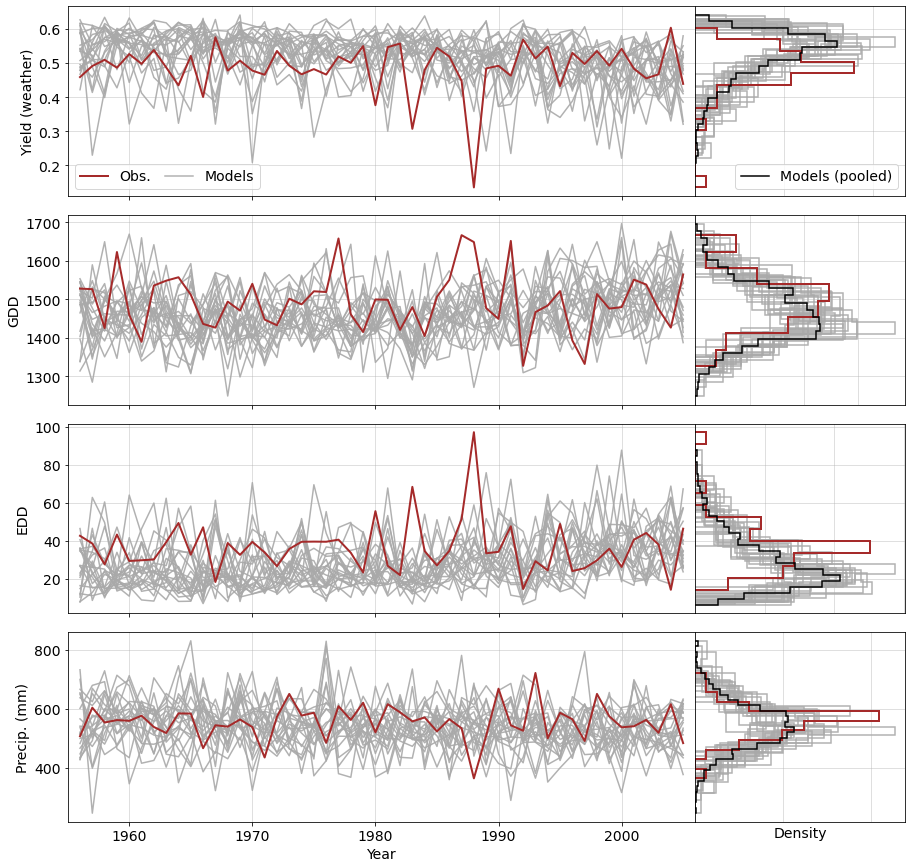

In [164]:
# Timeseries
fig, axs = plt.subplots(4,2, figsize=(15,15), sharey='row', gridspec_kw={'width_ratios': [3, 1], 'hspace':0.1, 'wspace':0})
axs=axs.flatten()

###############
# Plot style
###############
model_lw = 1.5
obs_lw = 2
# model_c = '#9ecae1'
model_c = 'darkgray'
obs_c = 'brown'
pooled_c = 'black'
model_alpha = 0.9

############################ 
############## Yield-Weather
############################ 

# Legend
ax=axs[0]
gmfd_weather_weighted.plot(y = 'weather', ax=ax, lw=obs_lw, label='Obs.', color=obs_c, zorder=10)
for model in nex_models[:1]:
    ax.plot(nex_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label='Models')
ax.legend(loc='lower left', ncol=2, columnspacing=1)

# Timeseries
ax=axs[0]
for model in nex_models[1:]:
    ax.plot(nex_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Yield (weather)')
ax.set_xlabel('')
ax.set_xlim([1955,2006])
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[1]
for model in nex_models[1:]:
    ax.hist(nex_weather_weighted[model]['weather'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    weather_pooled = np.append(weather_pooled, nex_weather_weighted[model]['weather'].values)
ax.hist(gmfd_weather_weighted['weather'], bins='fd', color=obs_c, histtype='step', lw=obs_lw, label=None, orientation='horizontal', density=True)
ax.hist(weather_pooled, bins='doane', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
# Legend
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([100],[100], color=pooled_c, lw=model_lw, label='Models (pooled)')
ax.legend(loc='lower right')
ax.grid(alpha=0.5)

############################ 
############### GDD
############################ 

# Timeseries
ax=axs[2]
gmfd_weather_weighted.plot(y = 'gdd', ax=ax, lw=obs_lw, legend=None, color=obs_c, zorder=10)
for model in nex_models:
    ax.plot(nex_weather_weighted[model]['gdd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('GDD')
ax.set_xlabel('')
ax.set_xlim([1955,2006])
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[3]
gdd_pooled = np.array([])
for model in nex_models:
    ax.hist(nex_weather_weighted[model]['gdd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    gdd_pooled = np.append(gdd_pooled, nex_weather_weighted[model]['gdd'].values)
gmfd_weather_weighted['gdd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(gdd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### EDD
############################ 

# Timeseries
ax=axs[4]
gmfd_weather_weighted.plot(y = 'edd', ax=ax, lw=obs_lw, legend=None, color=obs_c, zorder=10)
for model in nex_models:
    ax.plot(nex_weather_weighted[model]['edd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('EDD')
ax.set_xlabel('')
ax.set_xlim([1955,2006])
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[5]
edd_pooled = np.array([])
for model in nex_models:
    ax.hist(nex_weather_weighted[model]['edd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    edd_pooled = np.append(edd_pooled, nex_weather_weighted[model]['edd'].values)
gmfd_weather_weighted['edd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(edd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### Precip
############################ 

# Timeseries
ax=axs[6]
gmfd_weather_weighted.plot(y = 'prcp', ax=ax, lw=obs_lw, legend=None, color=obs_c, zorder=10)
for model in nex_models:
    ax.plot(nex_weather_weighted[model]['prcp'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Precip. (mm)')
ax.set_xlabel('Year')
ax.set_xlim([1955,2006])
ax.grid(alpha=0.5)

# Hist
ax=axs[7]
prcp_pooled = np.array([])
for model in nex_models:
    ax.hist(nex_weather_weighted[model]['prcp'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    prcp_pooled = np.append(prcp_pooled, nex_weather_weighted[model]['prcp'].values)
gmfd_weather_weighted['prcp'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(prcp_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.set_xlabel('Density')
ax.tick_params(axis='y', which='both', left=False)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.grid(alpha=0.5)

# Plot
plt.show()
# plt.savefig('../../figs/new/annual_all.pdf')

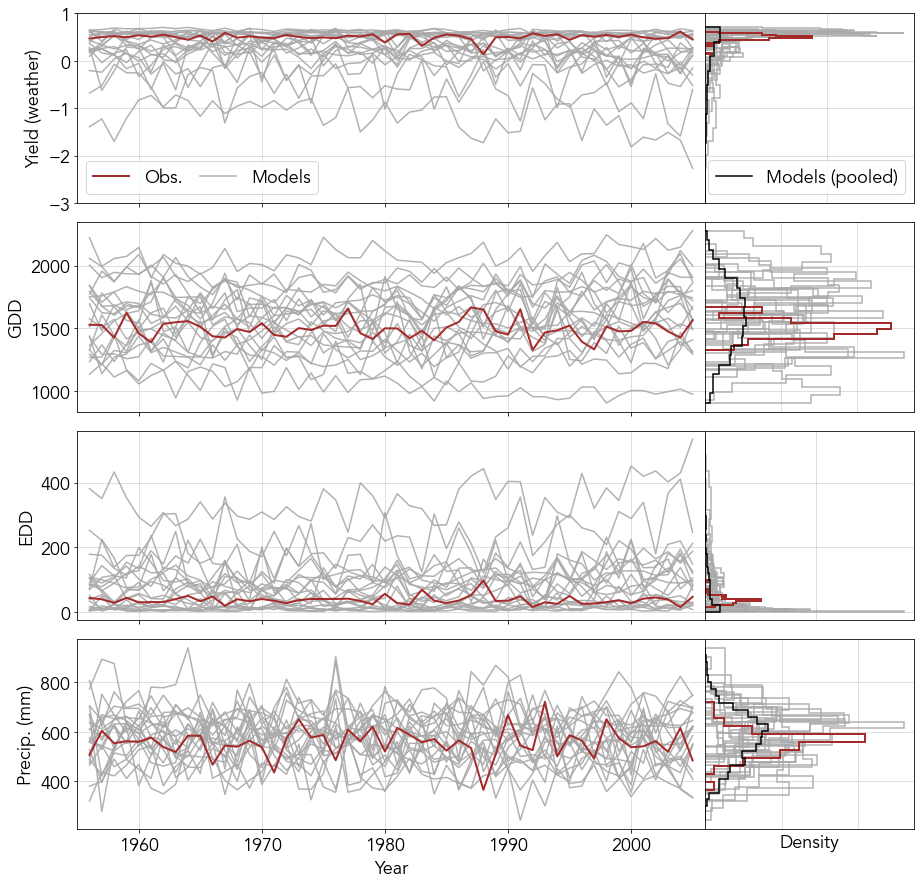

In [261]:
# Timeseries plot
fig, axs = plt.subplots(4,2, figsize=(15,15), sharey='row', gridspec_kw={'width_ratios': [3, 1], 'hspace':0.1, 'wspace':0})
axs=axs.flatten()

###############
# Plot style
###############
model_lw = 1.5
obs_lw = 2
# model_c = '#9ecae1'
model_c = 'darkgray'
obs_c = 'brown'
pooled_c = 'black'
model_alpha = 0.9

############################ 
############## Yield-Weather
############################ 

# Legend
ax=axs[0]
gmfd_weather_weighted.plot(y = 'weather', ax=ax, lw=obs_lw, label='Obs.', color=obs_c, zorder=10)
for model in cmip_models[:1]:
    ax.plot(cmip_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label='Models')
ax.legend(loc='lower left', ncol=2, columnspacing=1)

# Timeseries
ax=axs[0]
for model in cmip_models[1:]:
    ax.plot(cmip_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Yield (weather)')
ax.set_xlabel('')
ax.set_xlim([1955,2006])
ax.set_ylim([-3,1])
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[1]
for model in cmip_models[1:]:
    ax.hist(cmip_weather_weighted[model]['weather'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    weather_pooled = np.append(weather_pooled, cmip_weather_weighted[model]['weather'].values)
ax.hist(gmfd_weather_weighted['weather'], bins='fd', color=obs_c, histtype='step', lw=obs_lw, label=None, orientation='horizontal', density=True)
ax.hist(weather_pooled, bins='doane', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
# Legend
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([100],[100], color=pooled_c, lw=model_lw, label='Models (pooled)')
ax.legend(loc='lower right')
ax.grid(alpha=0.5)

############################ 
############### GDD
############################ 

# Timeseries
ax=axs[2]
gmfd_weather_weighted.plot(y = 'gdd', ax=ax, lw=obs_lw, legend=None, color=obs_c, zorder=10)
for model in cmip_models:
    ax.plot(cmip_weather_weighted[model]['gdd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('GDD')
ax.set_xlabel('')
ax.set_xlim([1955,2006])
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[3]
gdd_pooled = np.array([])
for model in cmip_models:
    ax.hist(cmip_weather_weighted[model]['gdd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    gdd_pooled = np.append(gdd_pooled, cmip_weather_weighted[model]['gdd'].values)
gmfd_weather_weighted['gdd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(gdd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### EDD
############################ 

# Timeseries
ax=axs[4]
gmfd_weather_weighted.plot(y = 'edd', ax=ax, lw=obs_lw, legend=None, color=obs_c, zorder=10)
for model in cmip_models:
    ax.plot(cmip_weather_weighted[model]['edd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('EDD')
ax.set_xlabel('')
ax.set_xlim([1955,2006])
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[5]
edd_pooled = np.array([])
for model in cmip_models:
    ax.hist(cmip_weather_weighted[model]['edd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    edd_pooled = np.append(edd_pooled, cmip_weather_weighted[model]['edd'].values)
gmfd_weather_weighted['edd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(edd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### Precip
############################ 

# Timeseries
ax=axs[6]
gmfd_weather_weighted.plot(y = 'prcp', ax=ax, lw=obs_lw, legend=None, color=obs_c, zorder=10)
for model in cmip_models:
    ax.plot(cmip_weather_weighted[model]['prcp'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Precip. (mm)')
ax.set_xlabel('Year')
ax.set_xlim([1955,2006])
ax.grid(alpha=0.5)

# Hist
ax=axs[7]
prcp_pooled = np.array([])
for model in cmip_models:
    ax.hist(cmip_weather_weighted[model]['prcp'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    prcp_pooled = np.append(prcp_pooled, cmip_weather_weighted[model]['prcp'].values)
gmfd_weather_weighted['prcp'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(prcp_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.set_xlabel('Density')
ax.tick_params(axis='y', which='both', left=False)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.grid(alpha=0.5)

# Plot
plt.show()
# plt.savefig('../../figs/new/annual_all.pdf')

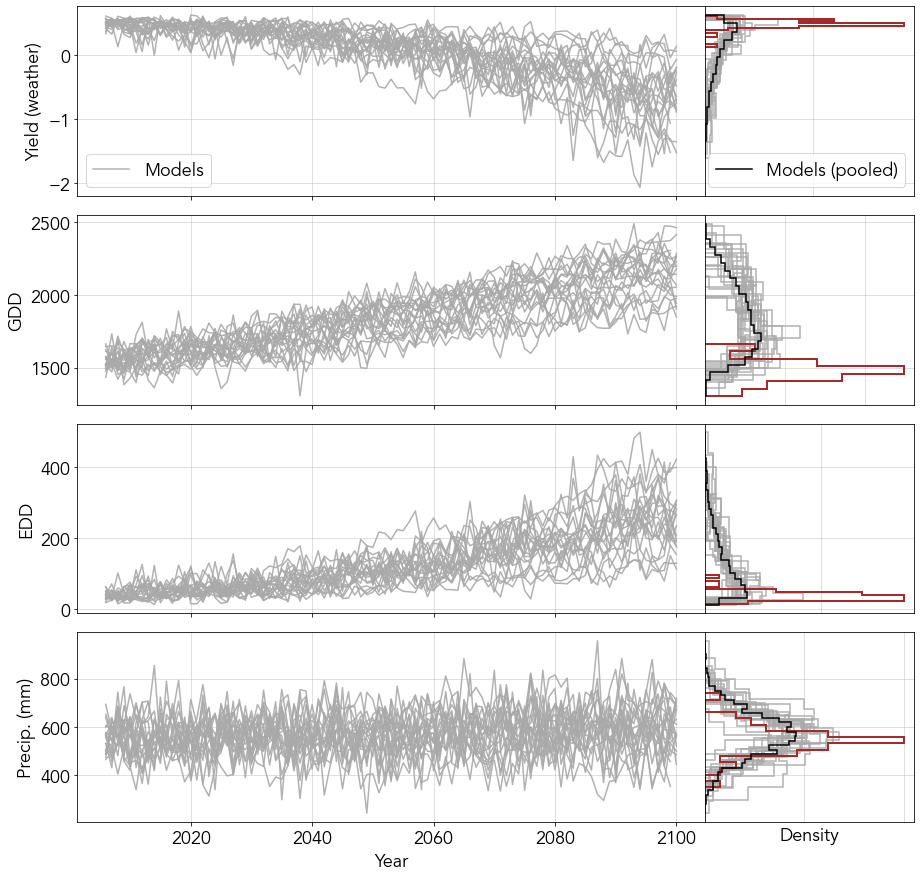

In [11]:
fig, axs = plt.subplots(4,2, figsize=(15,15), sharey='row', gridspec_kw={'width_ratios': [3, 1], 'hspace':0.1, 'wspace':0})
axs=axs.flatten()

###############
# Plot style
###############
model_lw = 1.5
obs_lw = 2
# model_c = '#9ecae1'
model_c = 'darkgray'
obs_c = 'brown'
pooled_c = 'black'
model_alpha = 0.9

############################ 
############## Yield-Weather
############################ 

# Legend
ax=axs[0]
for model in nex_models[:1]:
    ax.plot(nex_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label='Models')
ax.legend(loc='lower left', ncol=2, columnspacing=1)

# Timeseries
ax=axs[0]
for model in nex_models[1:]:
    ax.plot(nex_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Yield (weather)')
ax.set_xlabel('')
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[1]
weather_pooled = np.array([])
for model in nex_models[1:]:
    ax.hist(nex_weather_weighted[model]['weather'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    weather_pooled = np.append(weather_pooled, nex_weather_weighted[model]['weather'].values)
ax.hist(gmfd_weather_weighted['weather'], bins='fd', color=obs_c, histtype='step', lw=obs_lw, label=None, orientation='horizontal', density=True)
ax.hist(weather_pooled, bins='doane', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
# Legend
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([100],[100], color=pooled_c, lw=model_lw, label='Models (pooled)')
ax.legend(loc='lower right')
ax.grid(alpha=0.5)

############################ 
############### GDD
############################ 

# Timeseries
ax=axs[2]
for model in nex_models:
    ax.plot(nex_weather_weighted[model]['gdd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('GDD')
ax.set_xlabel('')
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[3]
gdd_pooled = np.array([])
for model in nex_models:
    ax.hist(nex_weather_weighted[model]['gdd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    gdd_pooled = np.append(gdd_pooled, nex_weather_weighted[model]['gdd'].values)
gmfd_weather_weighted['gdd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(gdd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### EDD
############################ 

# Timeseries
ax=axs[4]
for model in nex_models:
    ax.plot(nex_weather_weighted[model]['edd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('EDD')
ax.set_xlabel('')
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[5]
edd_pooled = np.array([])
for model in nex_models:
    ax.hist(nex_weather_weighted[model]['edd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    edd_pooled = np.append(edd_pooled, nex_weather_weighted[model]['edd'].values)
gmfd_weather_weighted['edd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(edd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### Precip
############################ 

# Timeseries
ax=axs[6]
for model in nex_models:
    ax.plot(nex_weather_weighted[model]['prcp'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Precip. (mm)')
ax.set_xlabel('Year')
ax.grid(alpha=0.5)

# Hist
ax=axs[7]
prcp_pooled = np.array([])
for model in nex_models:
    ax.hist(nex_weather_weighted[model]['prcp'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    prcp_pooled = np.append(prcp_pooled, nex_weather_weighted[model]['prcp'].values)
gmfd_weather_weighted['prcp'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(prcp_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.set_xlabel('Density')
ax.tick_params(axis='y', which='both', left=False)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.grid(alpha=0.5)

# Plot
plt.show()
# plt.savefig('../../figs/new/annual_all.pdf')

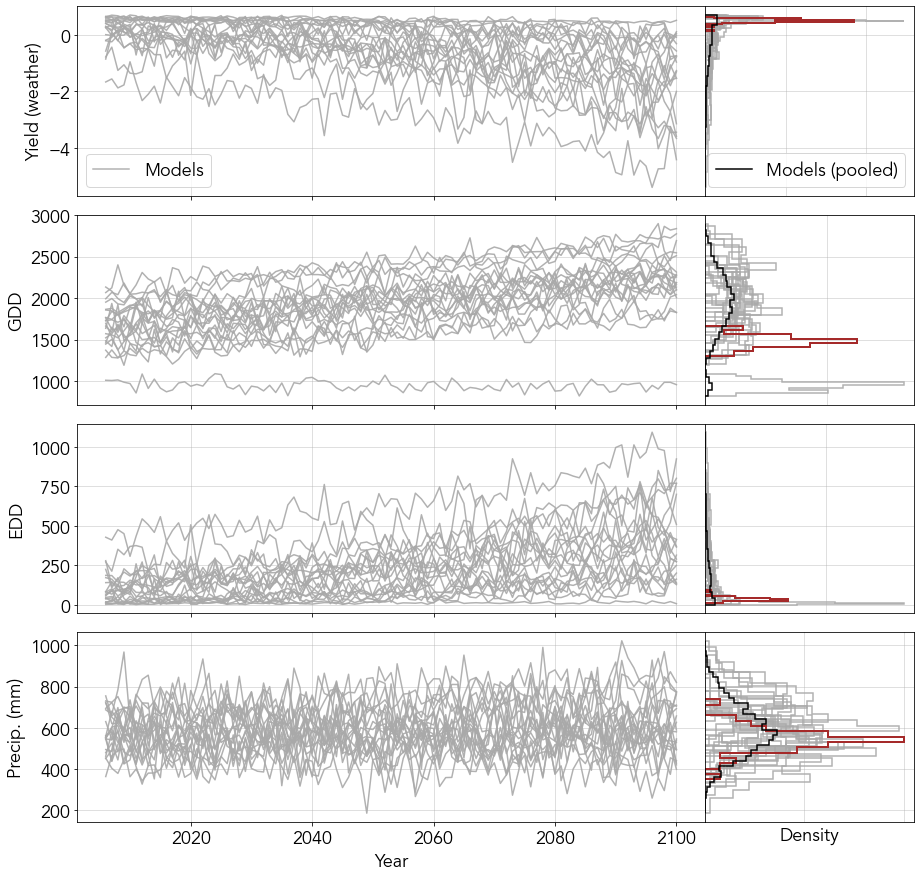

In [13]:
fig, axs = plt.subplots(4,2, figsize=(15,15), sharey='row', gridspec_kw={'width_ratios': [3, 1], 'hspace':0.1, 'wspace':0})
axs=axs.flatten()

###############
# Plot style
###############
model_lw = 1.5
obs_lw = 2
# model_c = '#9ecae1'
model_c = 'darkgray'
obs_c = 'brown'
pooled_c = 'black'
model_alpha = 0.9

############################ 
############## Yield-Weather
############################ 

# Legend
ax=axs[0]
for model in cmip_models[:1]:
    ax.plot(cmip_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label='Models')
ax.legend(loc='lower left', ncol=2, columnspacing=1)

# Timeseries
ax=axs[0]
for model in cmip_models[1:]:
    ax.plot(cmip_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Yield (weather)')
ax.set_xlabel('')
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[1]
weather_pooled = np.array([])
for model in cmip_models[1:]:
    ax.hist(cmip_weather_weighted[model]['weather'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    weather_pooled = np.append(weather_pooled, cmip_weather_weighted[model]['weather'].values)
ax.hist(gmfd_weather_weighted['weather'], bins='fd', color=obs_c, histtype='step', lw=obs_lw, label=None, orientation='horizontal', density=True)
ax.hist(weather_pooled, bins='doane', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
# Legend
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([100],[100], color=pooled_c, lw=model_lw, label='Models (pooled)')
ax.legend(loc='lower right')
ax.grid(alpha=0.5)

############################ 
############### GDD
############################ 

# Timeseries
ax=axs[2]
for model in cmip_models:
    ax.plot(cmip_weather_weighted[model]['gdd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('GDD')
ax.set_xlabel('')
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[3]
gdd_pooled = np.array([])
for model in cmip_models:
    ax.hist(cmip_weather_weighted[model]['gdd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    gdd_pooled = np.append(gdd_pooled, cmip_weather_weighted[model]['gdd'].values)
gmfd_weather_weighted['gdd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(gdd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### EDD
############################ 

# Timeseries
ax=axs[4]
for model in cmip_models:
    ax.plot(cmip_weather_weighted[model]['edd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('EDD')
ax.set_xlabel('')
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[5]
edd_pooled = np.array([])
for model in cmip_models:
    ax.hist(cmip_weather_weighted[model]['edd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    edd_pooled = np.append(edd_pooled, cmip_weather_weighted[model]['edd'].values)
gmfd_weather_weighted['edd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(edd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### Precip
############################ 

# Timeseries
ax=axs[6]
for model in cmip_models:
    ax.plot(cmip_weather_weighted[model]['prcp'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Precip. (mm)')
ax.set_xlabel('Year')
ax.grid(alpha=0.5)

# Hist
ax=axs[7]
prcp_pooled = np.array([])
for model in cmip_models:
    ax.hist(cmip_weather_weighted[model]['prcp'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    prcp_pooled = np.append(prcp_pooled, cmip_weather_weighted[model]['prcp'].values)
gmfd_weather_weighted['prcp'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(prcp_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.set_xlabel('Density')
ax.tick_params(axis='y', which='both', left=False)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.grid(alpha=0.5)

# Plot
plt.show()
# plt.savefig('../../figs/new/annual_all.pdf')

In [38]:
# Future summary stats
# NEX
nex_mean = [nex_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'].mean() for model in nex_models]
nex_sd = [nex_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'].std() for model in nex_models]
nex_q10 = [nex_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'].quantile(q=0.1) for model in nex_models]
nex_min = [nex_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'].min() for model in nex_models]

# CMIP
cmip_mean = [cmip_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'].mean() for model in cmip_models]
cmip_sd = [cmip_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'].std() for model in cmip_models]
cmip_q10 = [cmip_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'].quantile(q=0.1) for model in cmip_models]
cmip_min = [cmip_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'].min() for model in cmip_models]

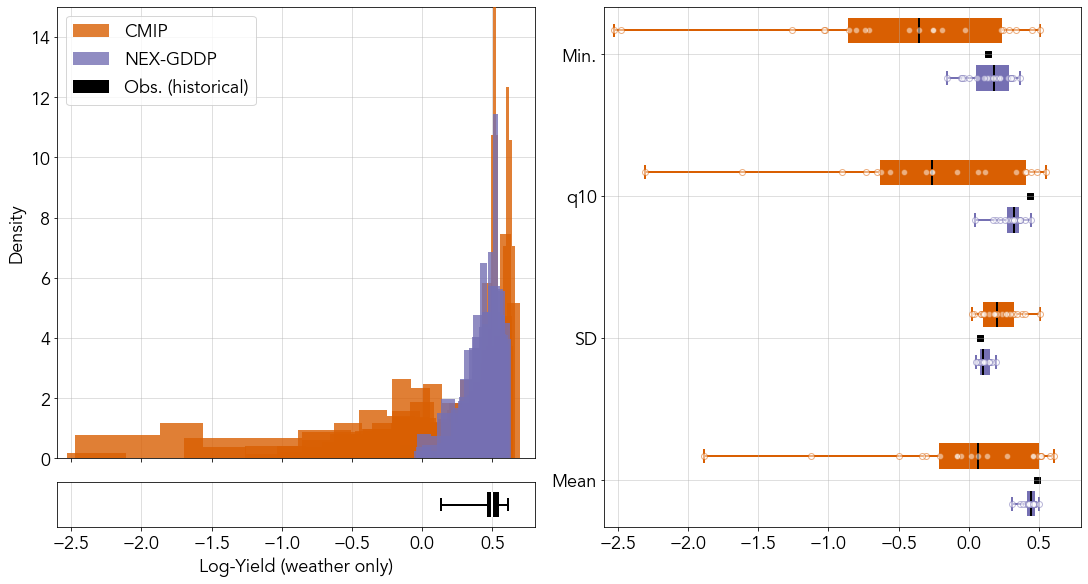

In [46]:
# Hist plot
fig = plt.figure(constrained_layout=True, figsize=(15,8))
gs = GridSpec(2, 2, figure=fig, height_ratios=[10,1], hspace=0.0)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

###############
# Plot style
###############
model_lw = 1.5
model_alpha = 0.8
nex_col = '#7570b3'
cmip_col = '#d95f02'

# Models
ax=ax1
# Legend
ax.hist(cmip_weather_weighted[cmip_models[0]].query('year <= 2030 and year <= 2059')['weather'], lw=model_lw, bins='fd', color=cmip_col, alpha=model_alpha, label='CMIP', density=True, zorder=10)
ax.hist(nex_weather_weighted[nex_models[0]].query('year <= 2030 and year <= 2059')['weather'], lw=model_lw, bins='fd', color=nex_col, alpha=model_alpha, label='NEX-GDDP', density=True, zorder=10)
ax.hist([100], lw=model_lw, color='black', label='Obs. (historical)')
ax.set_xlim([-2.6, 0.8])
ax.set_xticklabels('')
ax.legend()

# CMIP
for model in cmip_models[1:]:
    ax.hist(cmip_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'], lw=model_lw, bins='fd', color=cmip_col, alpha=model_alpha, label=None, density=True, zorder=10)

# NEX
for model in nex_models[1:]:
    ax.hist(nex_weather_weighted[model].query('year <= 2030 and year <= 2059')['weather'], lw=model_lw, bins='fd', color=nex_col, alpha=model_alpha, label=None, density=True, zorder=10)

ax.set_ylim([0,15])
ax.grid(alpha=0.5, zorder=0)
ax.set_ylabel('Density')

# Obs
ax=ax2
obs_bxplt = ax.boxplot(gmfd_weather_weighted['weather'],
           vert=False,
           patch_artist=True,
           medianprops=dict(linewidth=2, color='white'),
           boxprops=dict(linewidth=2, color='black'),
           whiskerprops=dict(linewidth=2, color='black'),
           capprops=dict(linewidth=2, color='black'),
           widths=0.5, whis=(0,100), zorder=10)

for patch in obs_bxplt['boxes']:
        patch.set_facecolor('black')
        
ax.set_yticks([])
ax.set_xlabel('Log-Yield (weather only)')
ax.set_xlim([-2.6, 0.8])
ax.grid(alpha=0.5, zorder=0)

# Return period analysis
# NEX
ax=ax3
nex_bxplt = ax.boxplot([nex_mean, nex_sd, nex_q10, nex_min],
                       positions=[1,4,7,10],
                       patch_artist=True,
                       medianprops=dict(linewidth=2, color='black'),
                       boxprops=dict(linewidth=2, color=nex_col),
                       whiskerprops=dict(linewidth=2, color=nex_col),
                       capprops=dict(linewidth=2, color=nex_col),
                       showfliers=False,
                       whis=(0,100),
                       vert=False,
                       zorder=1)

for patch in nex_bxplt['boxes']:
        patch.set_facecolor(nex_col)
        
ax.scatter(nex_min, [10 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(nex_q10, [7 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(nex_sd, [4 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(nex_mean, [1 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)

# CMIP
cmip_bxplt = ax.boxplot([cmip_mean, cmip_sd, cmip_q10, cmip_min],
                        positions=[2,5,8,11],
                        patch_artist=True,
                        medianprops=dict(linewidth=2, color='black'),
                        boxprops=dict(linewidth=2, color=cmip_col),
                        whiskerprops=dict(linewidth=2, color=cmip_col),
                        capprops=dict(linewidth=2, color=cmip_col),
                        showfliers=False,
                        whis=(0,100),
                        vert=False,
                        zorder=1)

for patch in cmip_bxplt['boxes']:
        patch.set_facecolor(cmip_col)
        
ax.scatter(cmip_min, [11 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(cmip_q10, [8 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(cmip_sd, [5 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(cmip_mean, [2 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)

ax.set_yticks([1.5, 4.5, 7.5, 10.5])
ax.set_yticklabels(['Mean', 'SD', 'q10', 'Min.'])
ax.grid(alpha=0.5)
ax.set_xlim([-2.6, 0.8])

# Obs
ax.scatter([gmfd_weather_weighted['weather'].mean(),
            gmfd_weather_weighted['weather'].std(),
            gmfd_weather_weighted['weather'].quantile(q=0.1),
            gmfd_weather_weighted['weather'].min()], [1.5, 4.5, 7.5, 10.5], color='black', marker='s')

# plt.savefig('../../figs/new/future_all.pdf')
plt.show()